In [2]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
from models.deepflybrain import DeepFlyBrain

device = torch.device(f'cuda:0')
print(f"Using {device} device")

Using cuda:0 device


In [4]:
with open('configs/config_ctdnsmpl_top1k.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dfb_ctdnsmpl_1k_2025-05-29_08-08-57'

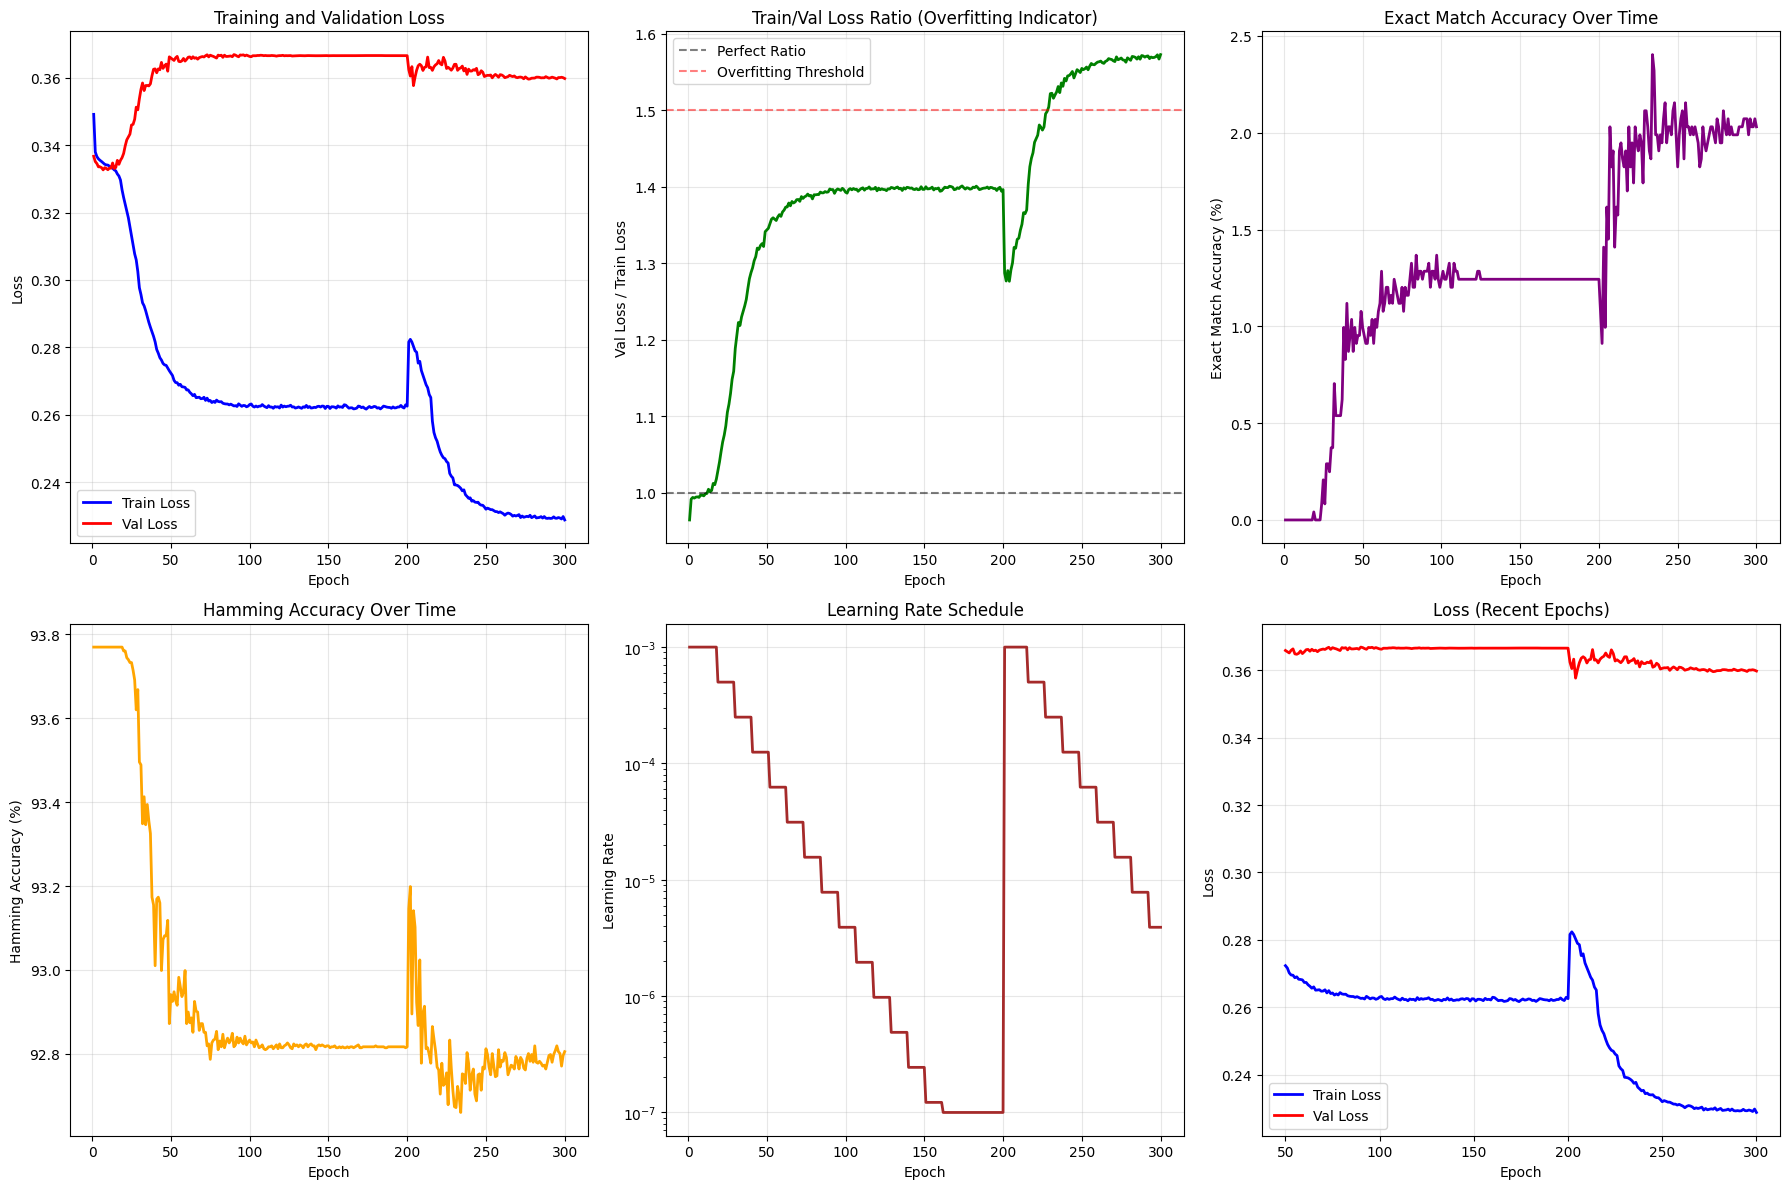

Training Summary:
Initial Train Loss: 0.349131
Final Train Loss: 0.228766
Initial Val Loss: 0.336697
Final Val Loss: 0.359761
Best Val Loss: 0.332656 (Epoch 7)
Best Exact Match Acc: 0.0240 (Epoch 234)
Best Hamming Acc: 0.9377 (Epoch 1)
Final Train/Val Ratio: 1.573


In [5]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

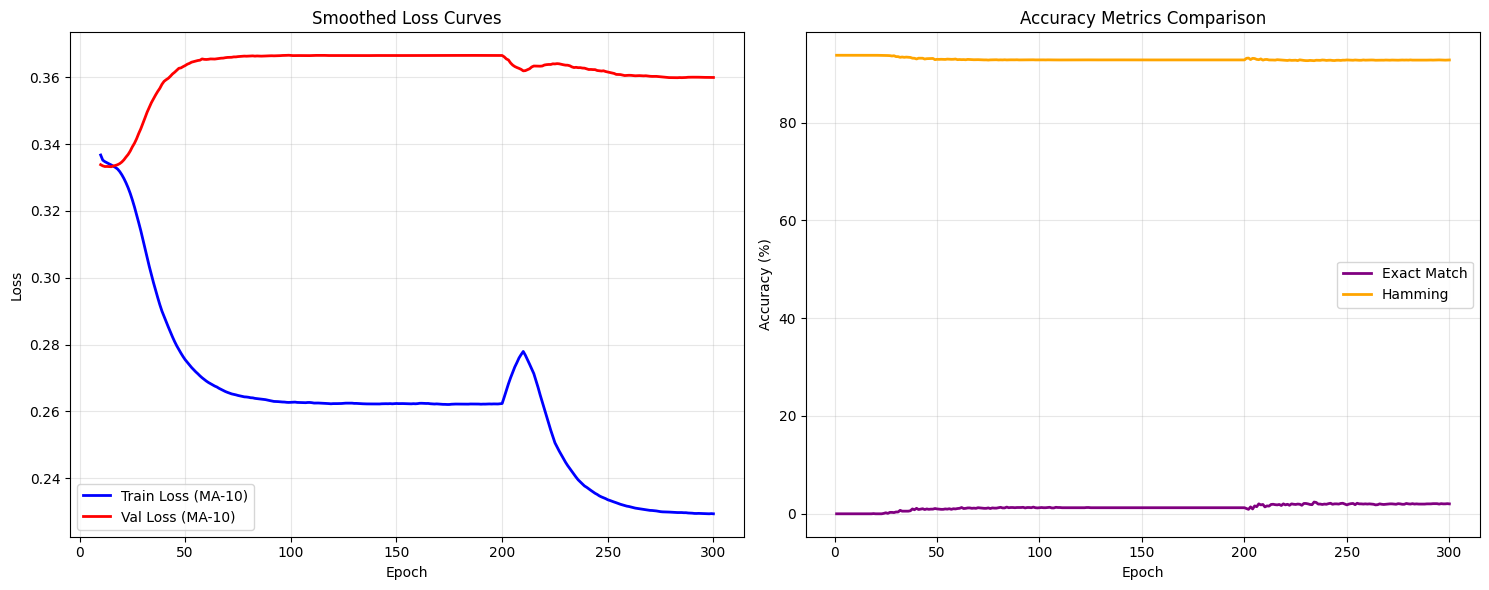

In [6]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

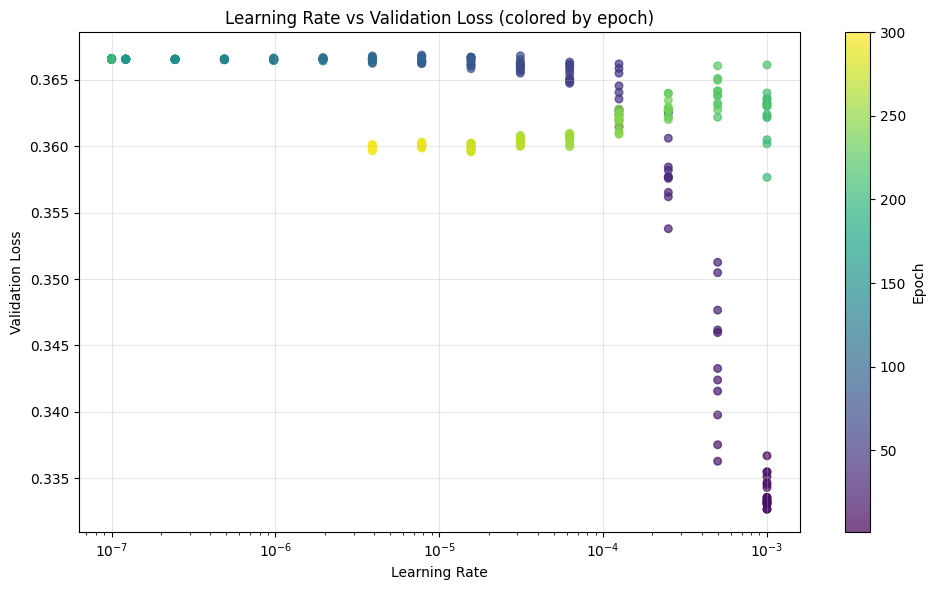

In [7]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [8]:
# Training phases analysis
print("Training Phases Analysis:")
print("=" * 50)

# Phase 1: Initial training (epochs 1-50)
phase1 = training_df[training_df['epoch'] <= 50]
print(f"Phase 1 (Epochs 1-50):")
print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# Phase 2: Middle training (epochs 51-200)
phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
print(f"\nPhase 2 (Epochs 51-200):")
print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# Phase 3: Fine-tuning (epochs 201-300)
phase3 = training_df[training_df['epoch'] > 200]
print(f"\nPhase 3 (Epochs 201-300):")
print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# Identify potential overfitting
overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
if len(overfitting_epochs) > 0:
    print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
    print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
    print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
else:
    print(f"\nNo significant overfitting detected (all ratios < 1.5)")

Training Phases Analysis:
Phase 1 (Epochs 1-50):
  Loss reduction: 0.3491 → 0.2723
  Val loss reduction: 0.3367 → 0.3659
  Accuracy improvement: 0.0000 → 0.0099

Phase 2 (Epochs 51-200):
  Loss reduction: 0.2716 → 0.2625
  Val loss reduction: 0.3655 → 0.3665
  Best accuracy: 0.0137

Phase 3 (Epochs 201-300):
  Loss reduction: 0.2816 → 0.2288
  Val loss reduction: 0.3624 → 0.3598
  Best accuracy: 0.0240

Potential overfitting detected in 72 epochs:
  First occurrence: Epoch 229
  Worst ratio: 1.573 at epoch 300


In [6]:
# Resume model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/final_model.pth')

model = DeepFlyBrain(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [8]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [9]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [11]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.005028092 0.9995252
Prediction shape: (16087, 18)
Target shape: (16087, 18)


In [12]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0622
Topic 1: 0.0622
Topic 2: 0.0622
Topic 3: 0.0622
Topic 4: 0.0622
Topic 5: 0.0622
Topic 6: 0.0622
Topic 7: 0.0622
Topic 8: 0.0622
Topic 9: 0.0622
Topic 10: 0.0622
Topic 11: 0.0622
Topic 12: 0.0622
Topic 13: 0.0622
Topic 14: 0.0622
Topic 15: 0.0622
Topic 16: 0.0622
Topic 17: 0.0622


In [13]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[14970   117]
 [  272   728]]

Topic 1:
[[15040    47]
 [  319   681]]

Topic 2:
[[15046    41]
 [  306   694]]

Topic 3:
[[15067    20]
 [  294   706]]

Topic 4:
[[15028    59]
 [  307   693]]

Topic 5:
[[15038    49]
 [  300   700]]

Topic 6:
[[15025    62]
 [  301   699]]

Topic 7:
[[14989    98]
 [  306   694]]

Topic 8:
[[15066    21]
 [  307   693]]

Topic 9:
[[15055    32]
 [  287   713]]

Topic 10:
[[15029    58]
 [  289   711]]

Topic 11:
[[15048    39]
 [  318   682]]

Topic 12:
[[15072    15]
 [  275   725]]

Topic 13:
[[14960   127]
 [  298   702]]

Topic 14:
[[15059    28]
 [  314   686]]

Topic 15:
[[15056    31]
 [  306   694]]

Topic 16:
[[15048    39]
 [  294   706]]

Topic 17:
[[15030    57]
 [  284   716]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.9319, auPR: 0.8147, F1: 0.7892


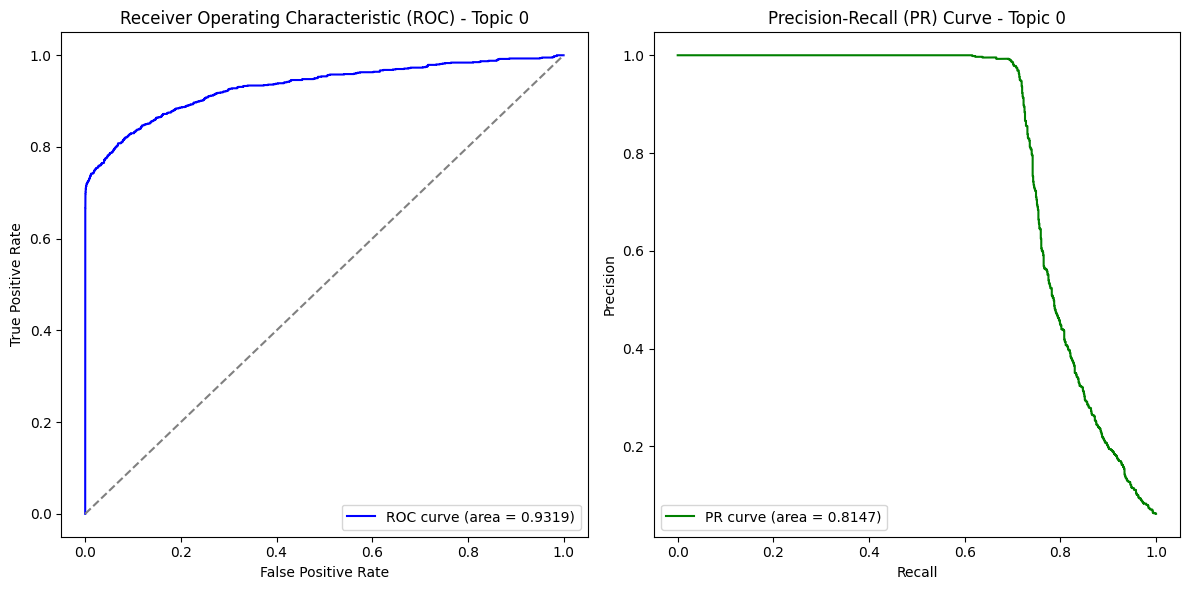

Evaluating topic 1
Topic 1 - auROC: 0.9255, auPR: 0.7970, F1: 0.7882


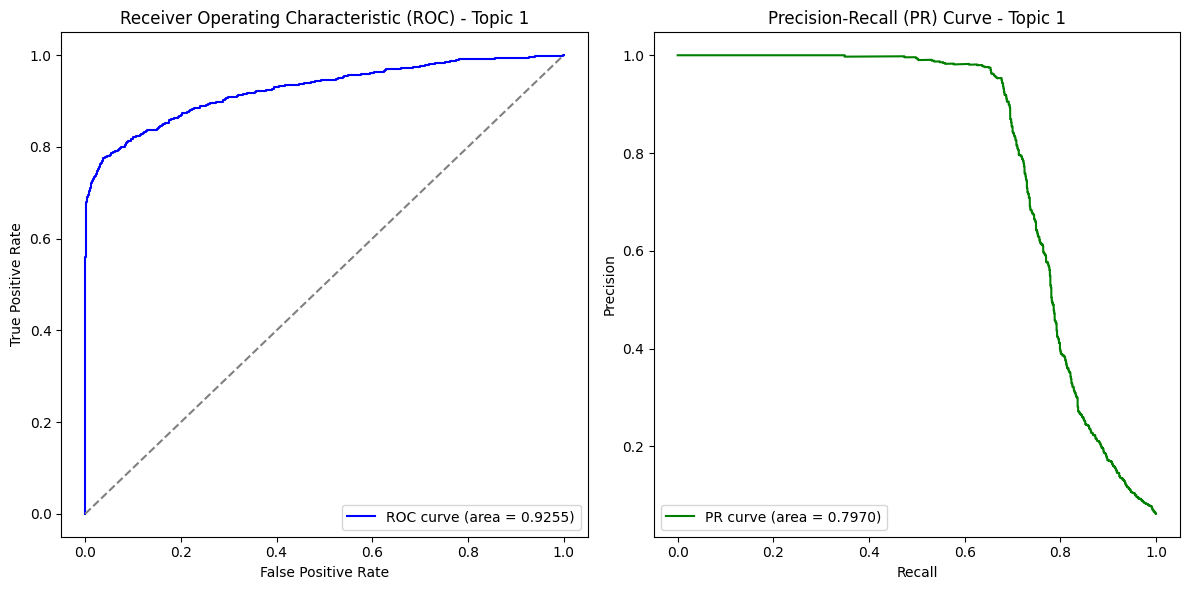

Evaluating topic 2
Topic 2 - auROC: 0.9151, auPR: 0.7881, F1: 0.8000


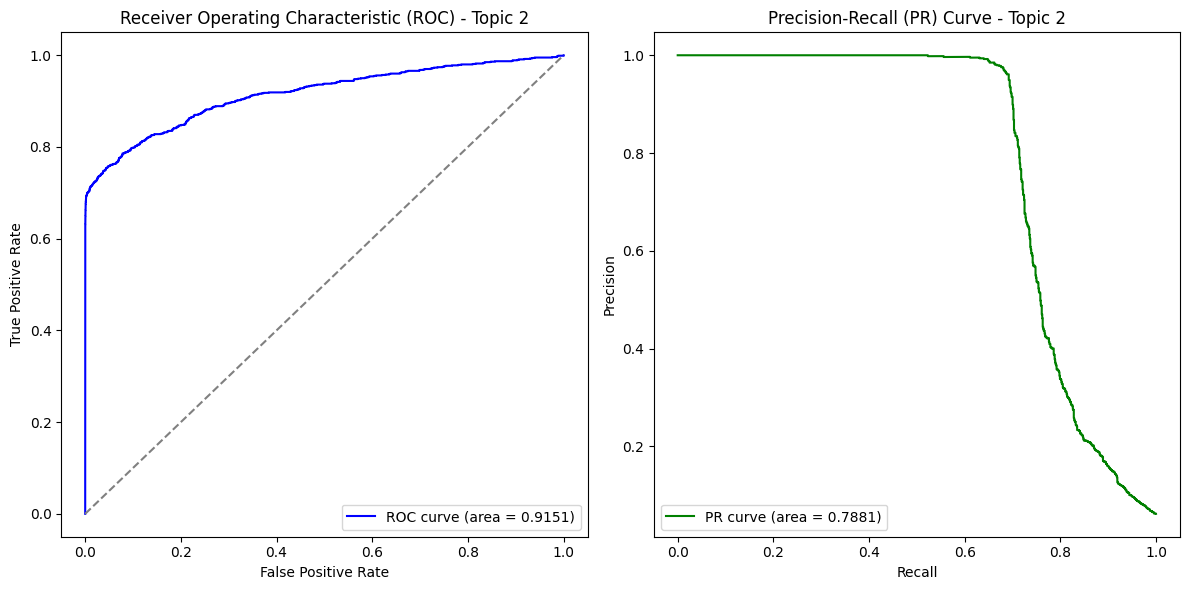

Evaluating topic 3
Topic 3 - auROC: 0.9359, auPR: 0.8093, F1: 0.8181


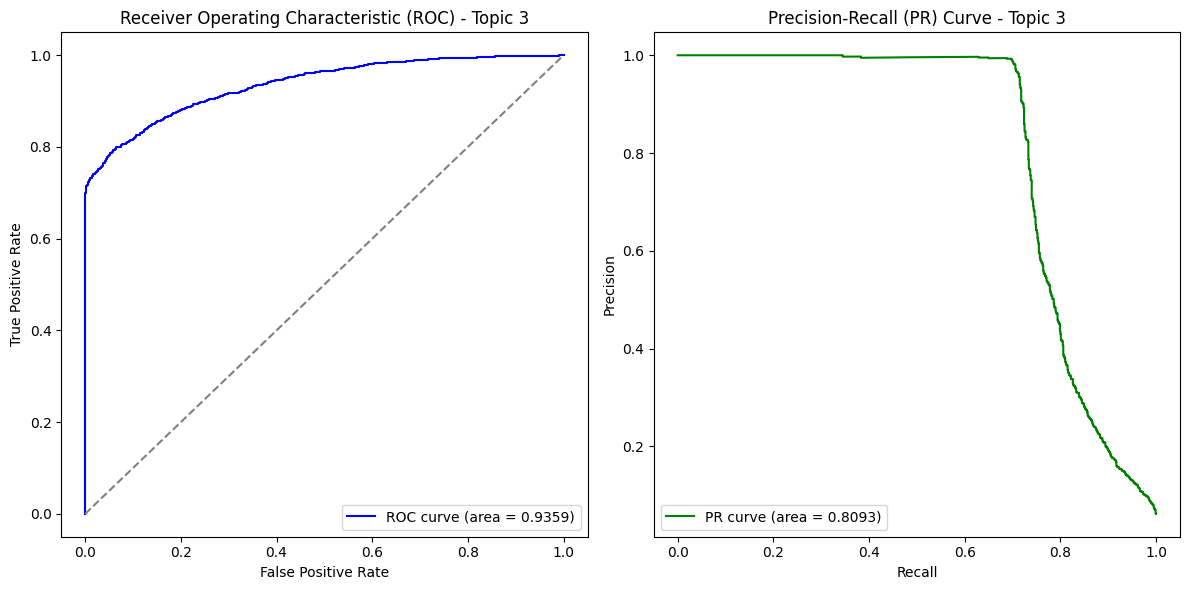

Evaluating topic 4
Topic 4 - auROC: 0.9212, auPR: 0.7992, F1: 0.7911


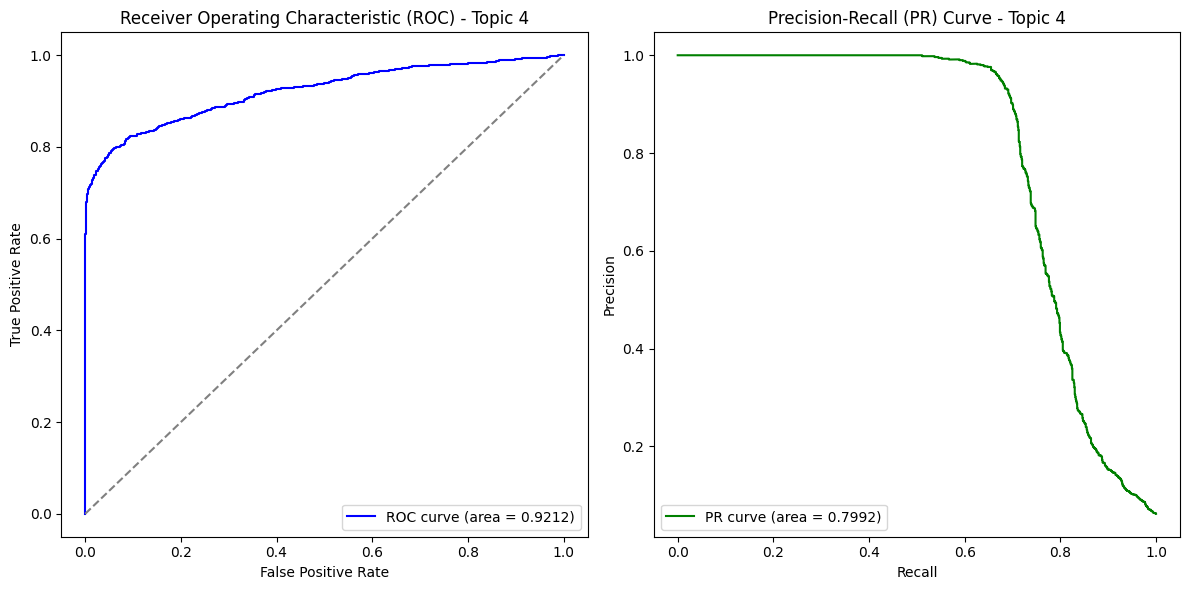

Evaluating topic 5
Topic 5 - auROC: 0.9126, auPR: 0.7846, F1: 0.8005


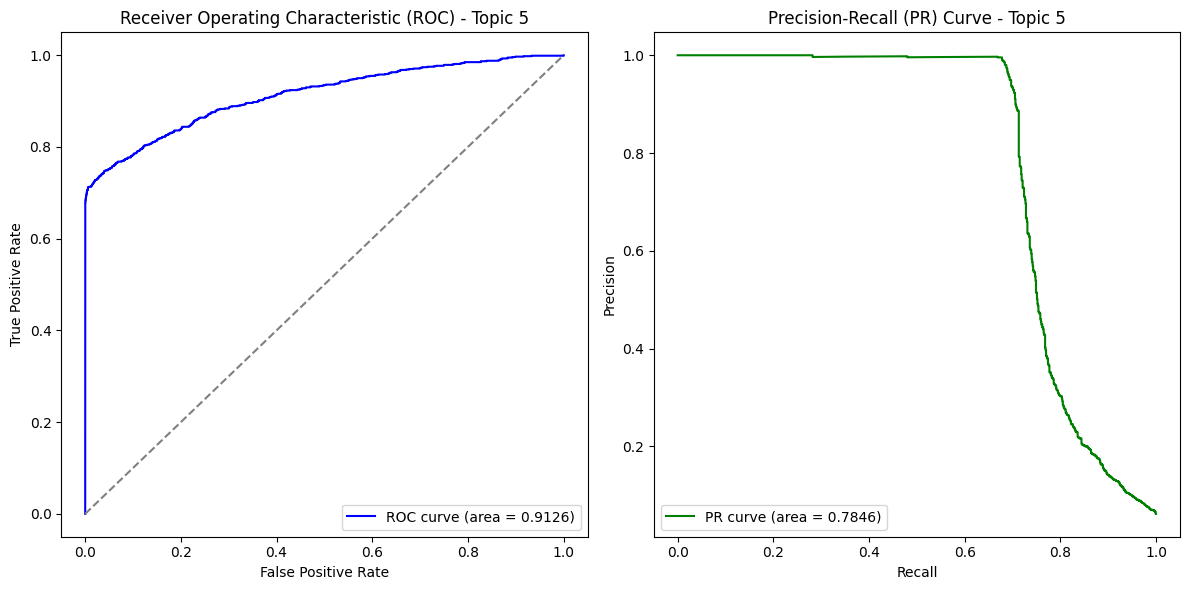

Evaluating topic 6
Topic 6 - auROC: 0.9284, auPR: 0.7994, F1: 0.7939


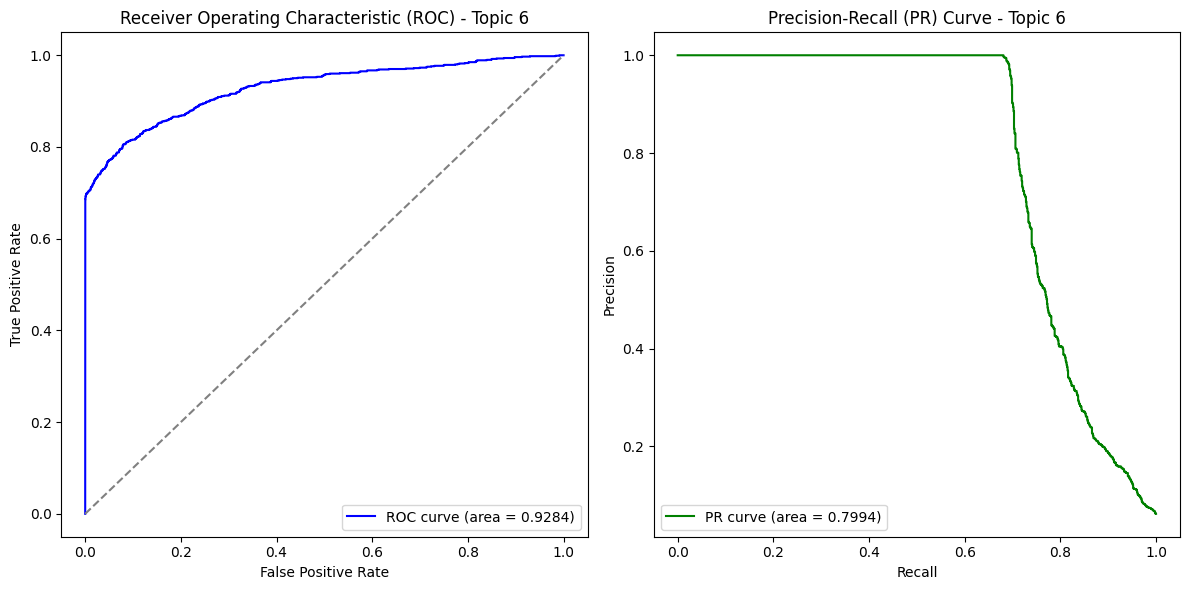

Evaluating topic 7
Topic 7 - auROC: 0.9180, auPR: 0.7830, F1: 0.7746


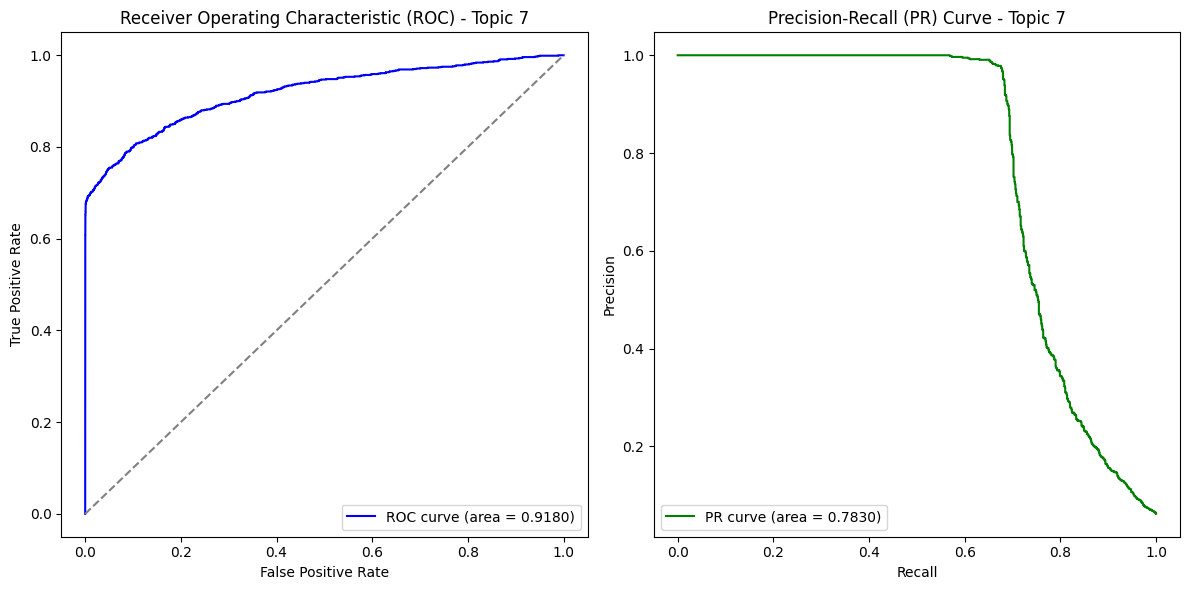

Evaluating topic 8
Topic 8 - auROC: 0.9133, auPR: 0.7931, F1: 0.8086


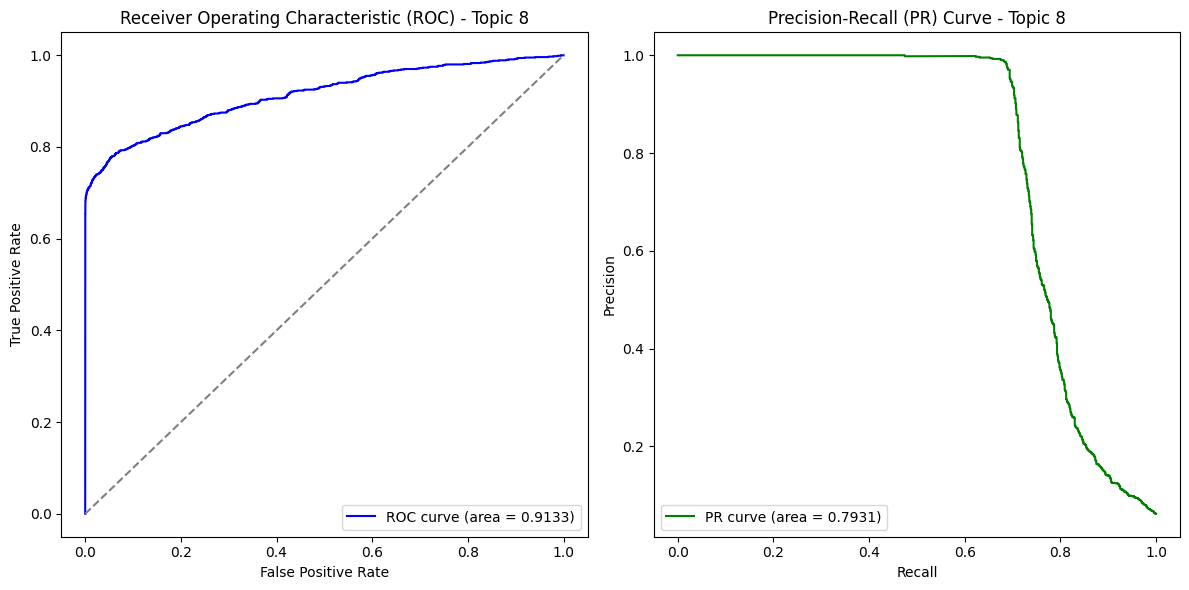

Evaluating topic 9
Topic 9 - auROC: 0.9241, auPR: 0.8019, F1: 0.8172


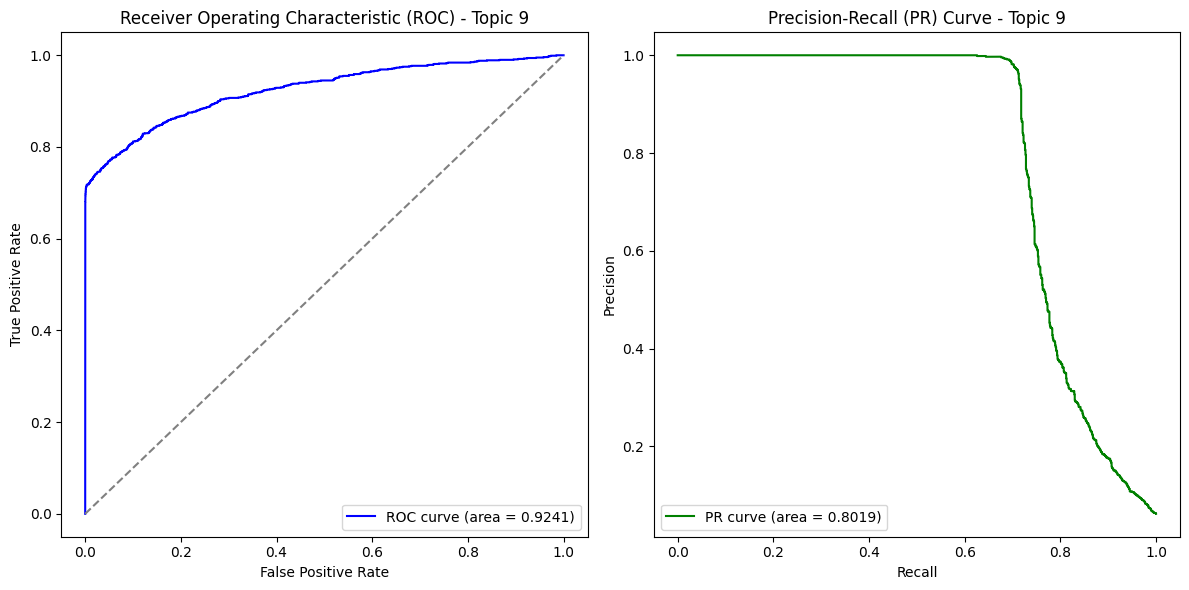

Evaluating topic 10
Topic 10 - auROC: 0.9254, auPR: 0.8028, F1: 0.8038


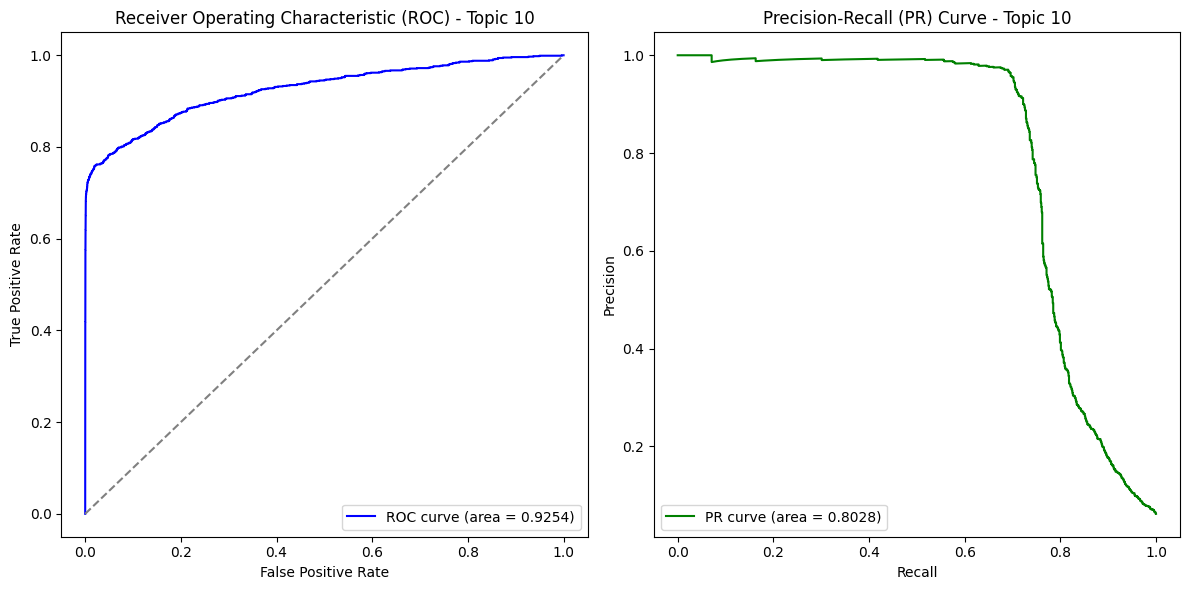

Evaluating topic 11
Topic 11 - auROC: 0.9183, auPR: 0.7965, F1: 0.7926


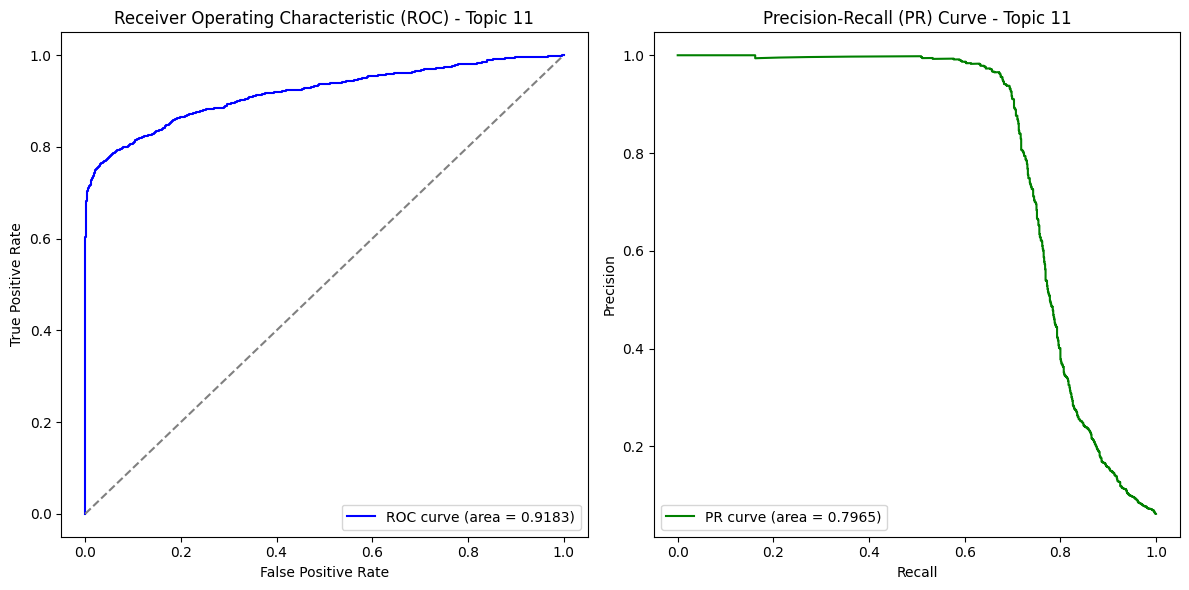

Evaluating topic 12
Topic 12 - auROC: 0.9182, auPR: 0.8083, F1: 0.8333


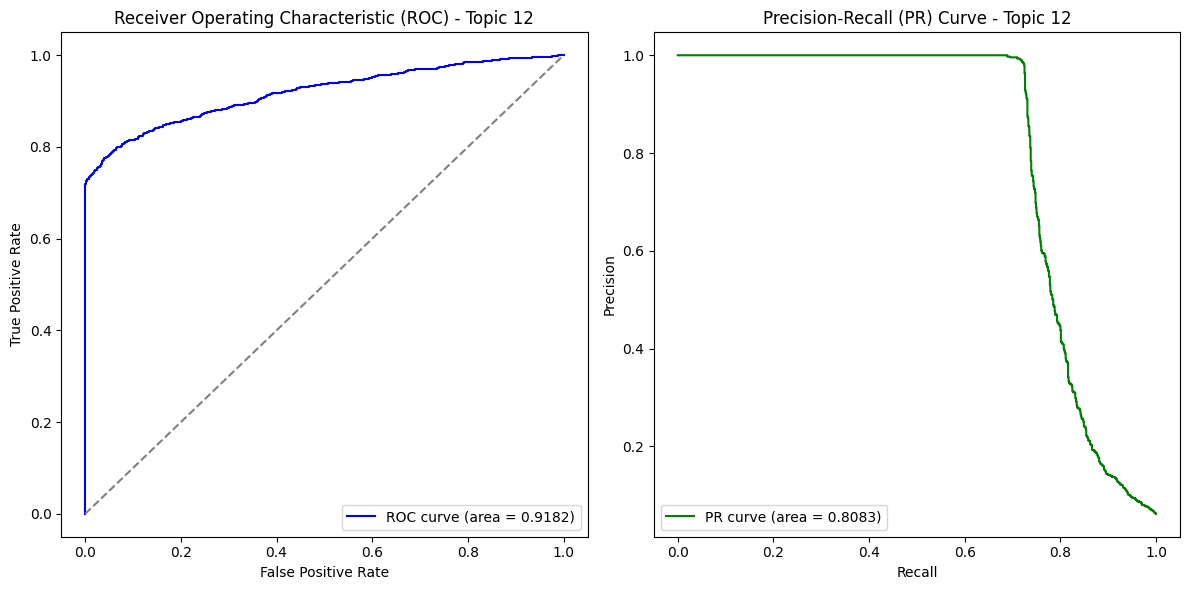

Evaluating topic 13
Topic 13 - auROC: 0.9207, auPR: 0.7888, F1: 0.7676


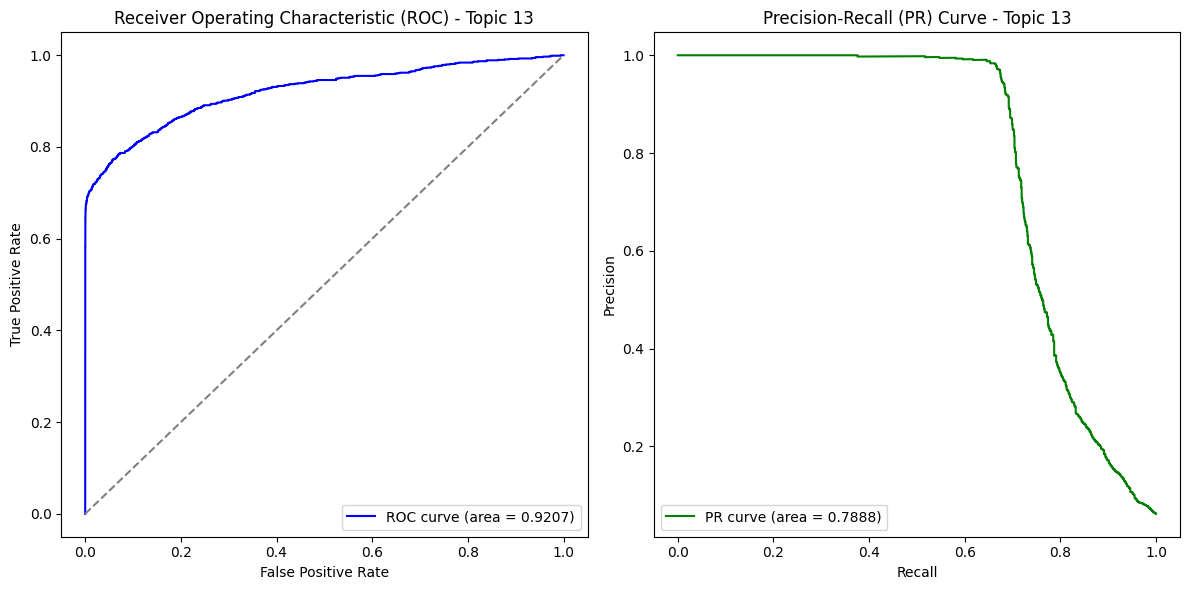

Evaluating topic 14
Topic 14 - auROC: 0.9251, auPR: 0.8012, F1: 0.8005


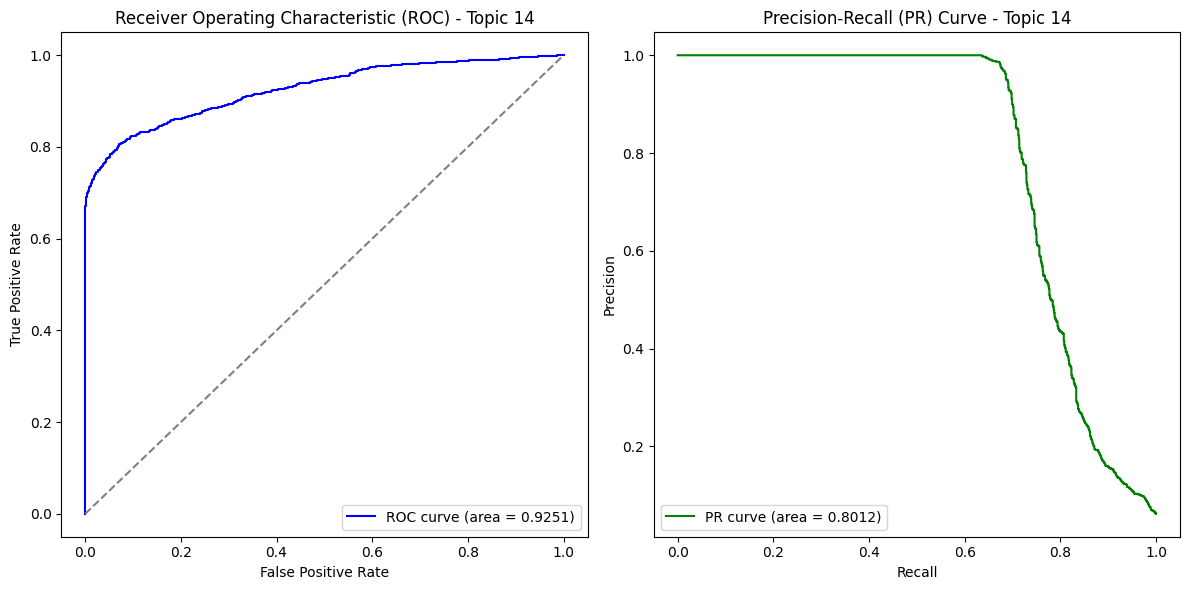

Evaluating topic 15
Topic 15 - auROC: 0.9109, auPR: 0.7871, F1: 0.8046


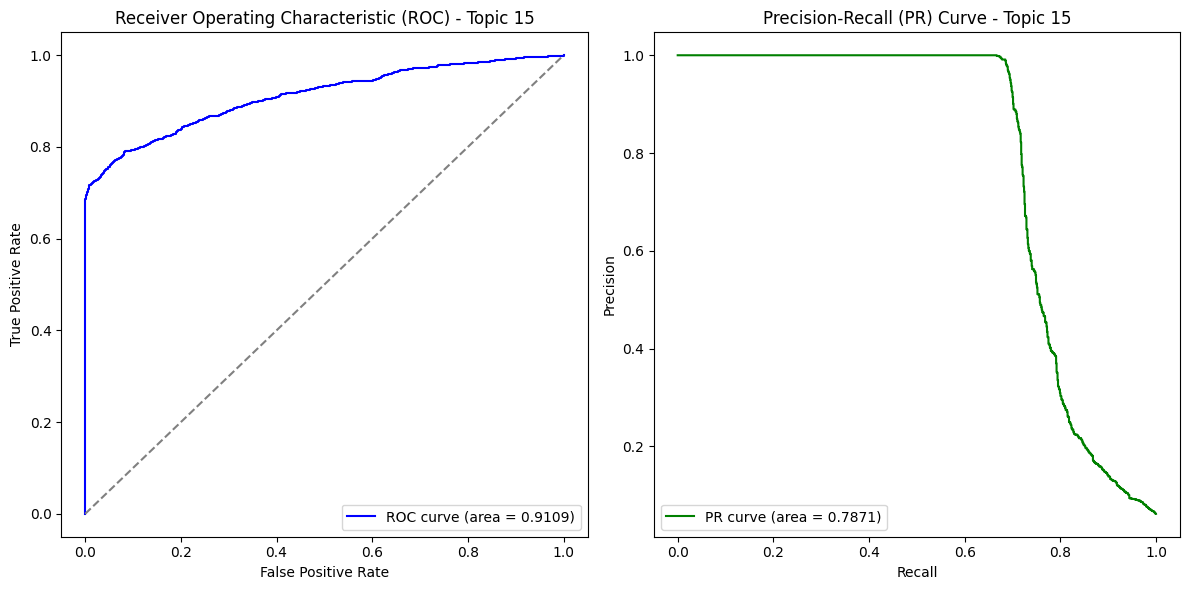

Evaluating topic 16
Topic 16 - auROC: 0.9190, auPR: 0.8048, F1: 0.8092


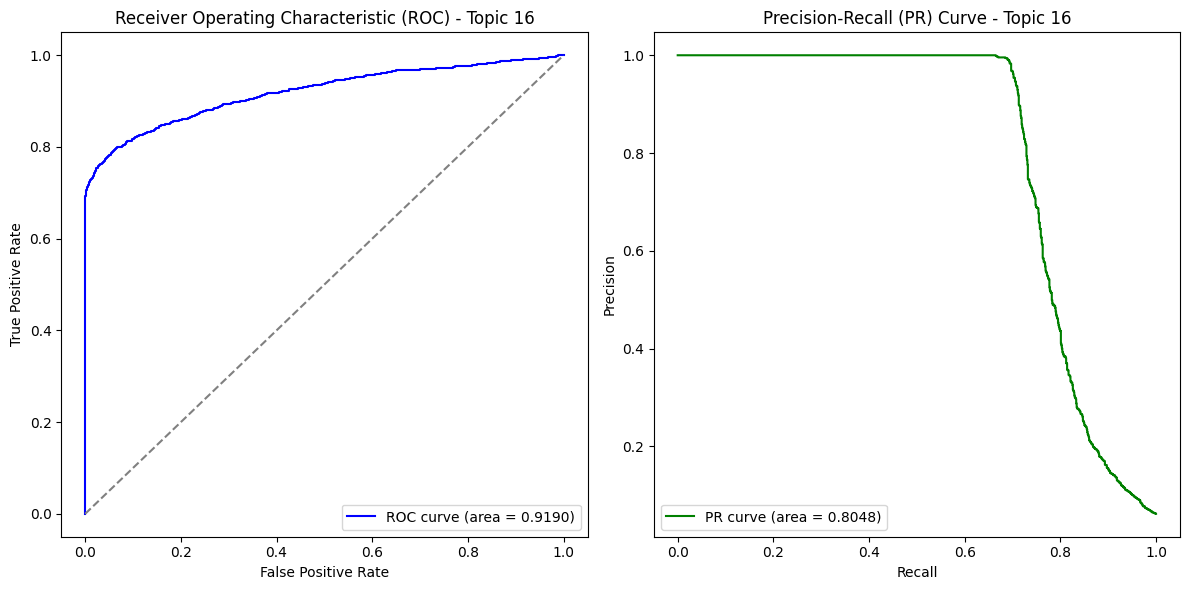

Evaluating topic 17
Topic 17 - auROC: 0.9263, auPR: 0.8041, F1: 0.8077


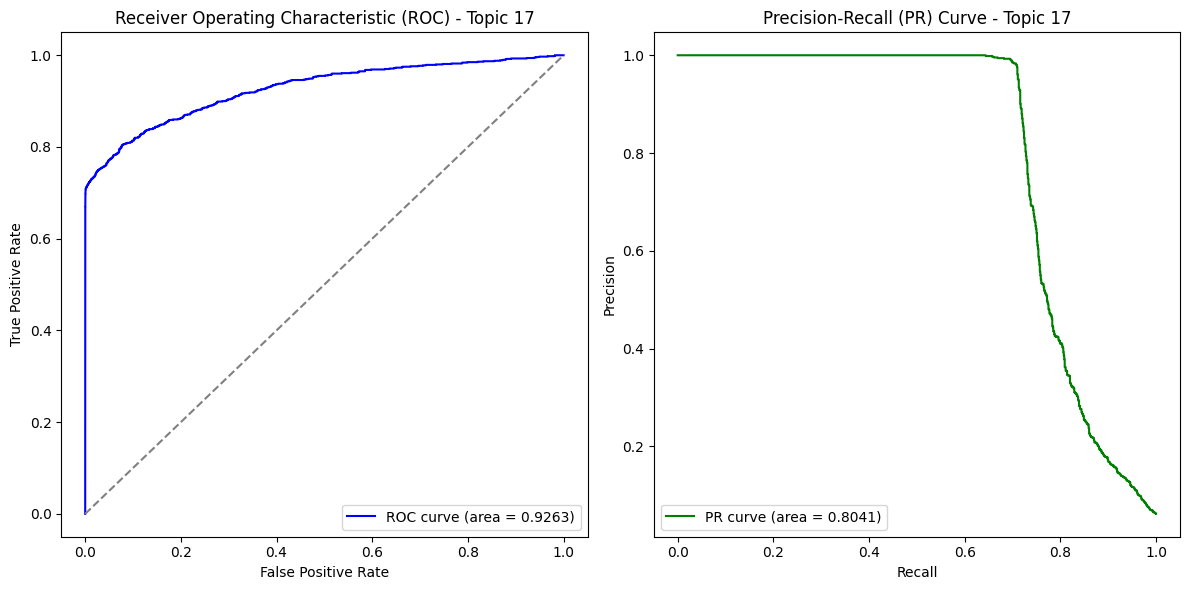

In [36]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [37]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.9217 ± 0.0066
Mean auPR: 0.7980 ± 0.0087
Mean F1: 0.8000 ± 0.0151
Exact Match Accuracy: 0.6991
Hamming Accuracy: 0.9782


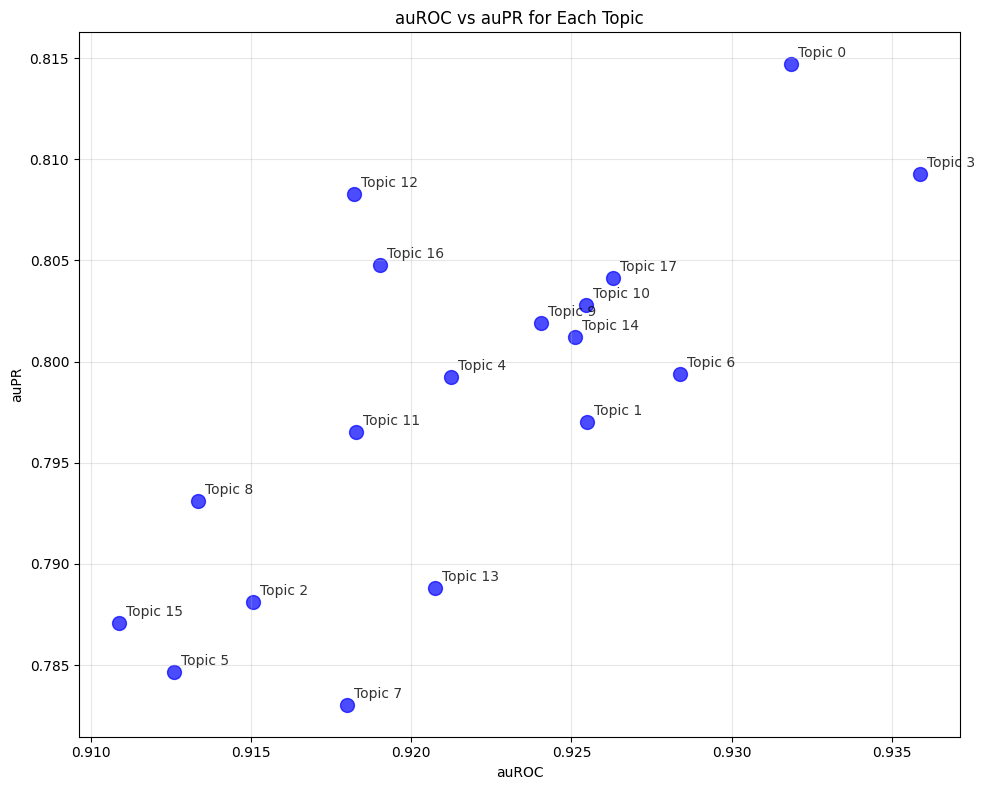

In [39]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

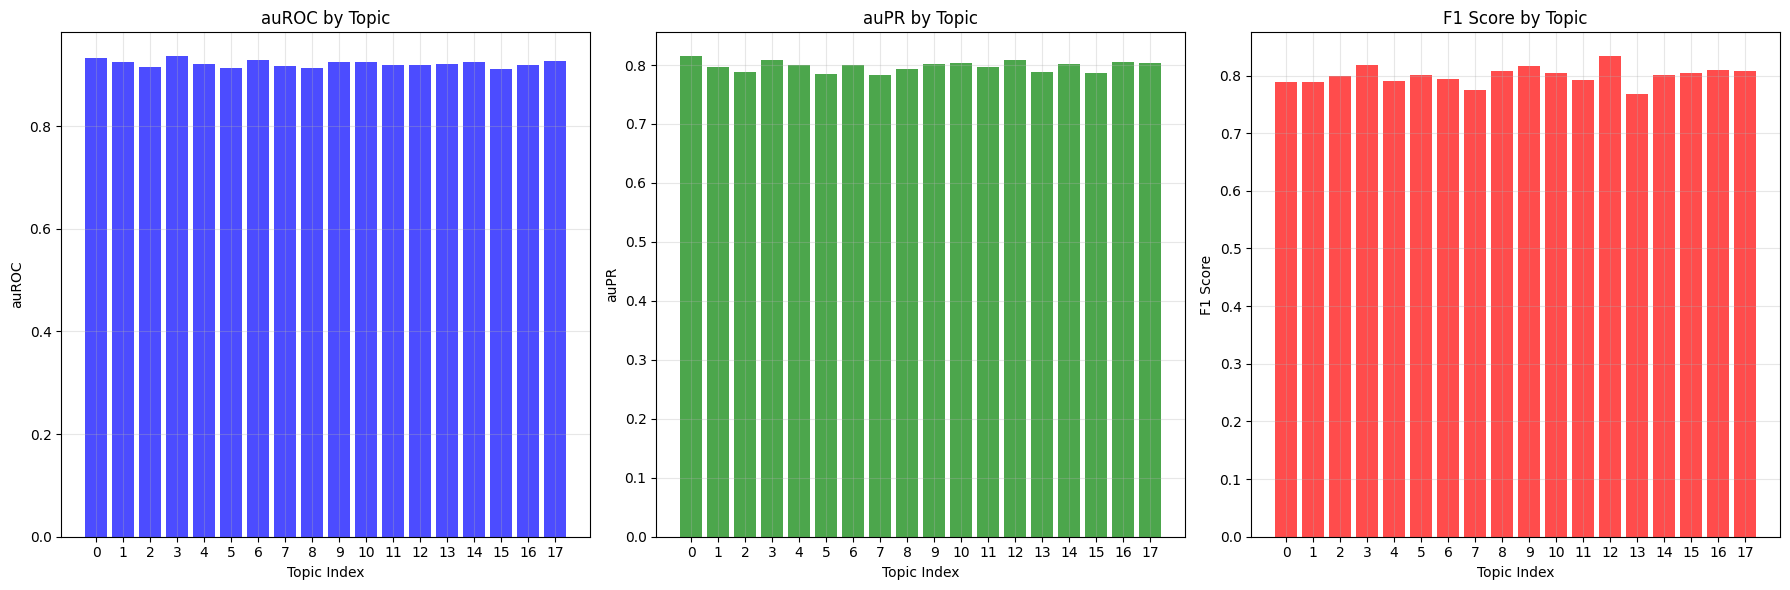

In [40]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

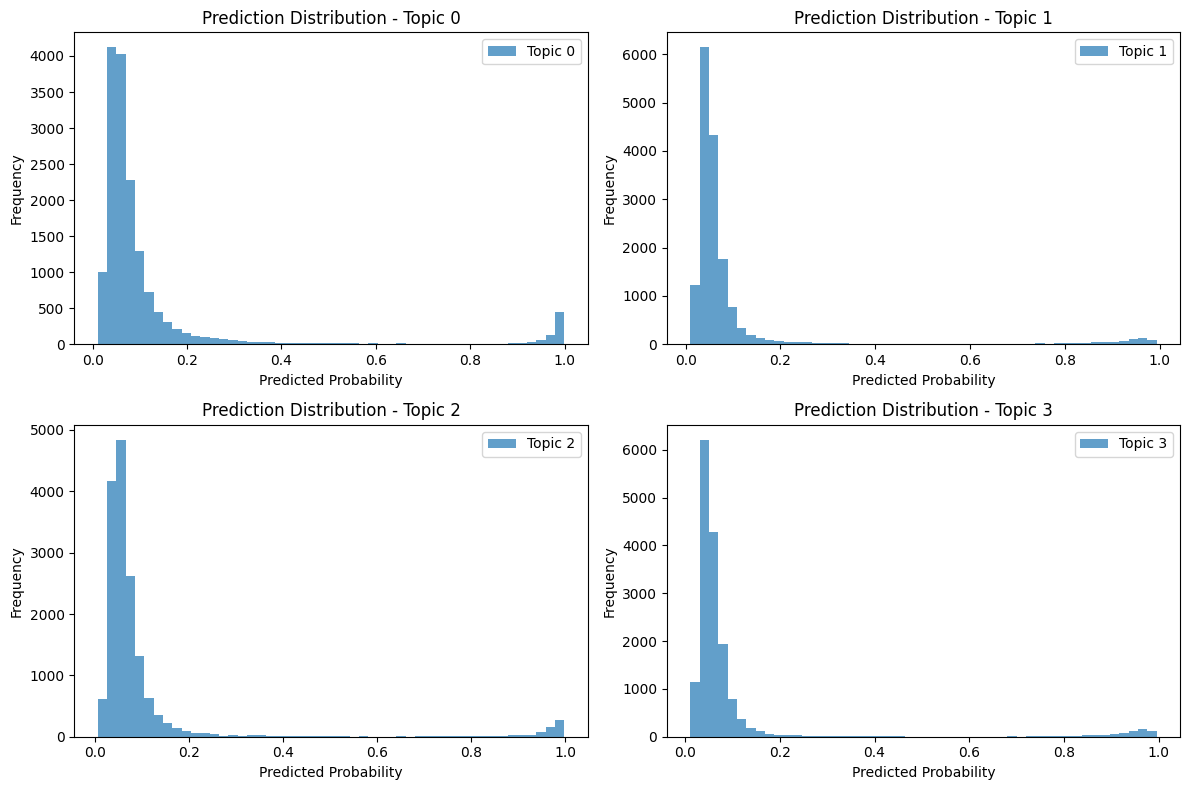


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.06504862 0.02802654 0.03000135 0.073985   0.03716756 0.03723011
 0.05425427 0.05091542 0.7963877  0.06474974 0.03589202 0.92217183
 0.03830564 0.0515318  0.01693982 0.03438609 0.04373344 0.04932981]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.06761147 0.05014666 0.05760525 0.04668198 0.94856673 0.09496029
 0.07858249 0.04815761 0.12321681 0.04852872 0.08021564 0.04179961
 0.05152392 0.05401814 0.03456966 0.07769839 0.04926123 0.06866305]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.03311297 0.9851494  0.04491369 0.08835692 0.0305131  0.05077548
 0.04498632 0.04803671 0.03065424 0.0380099  0.03350426 0.0199286
 0.05474138 0.04454112 0.08154928 0.06596711 0.03446672 0.03740457]
  Actual:    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

In [41]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [14]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [15]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.008950538 0.9660401
Prediction shape: (2414, 18)
Target shape: (2414, 18)


In [16]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0588
Topic 1: 0.0700
Topic 2: 0.0597
Topic 3: 0.0572
Topic 4: 0.0572
Topic 5: 0.0634
Topic 6: 0.0626
Topic 7: 0.0617
Topic 8: 0.0638
Topic 9: 0.0663
Topic 10: 0.0572
Topic 11: 0.0588
Topic 12: 0.0580
Topic 13: 0.0609
Topic 14: 0.0696
Topic 15: 0.0630
Topic 16: 0.0663
Topic 17: 0.0572


In [17]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[2215   57]
 [ 135    7]]

Topic 1:
[[2226   19]
 [ 167    2]]

Topic 2:
[[2247   23]
 [ 143    1]]

Topic 3:
[[2270    6]
 [ 137    1]]

Topic 4:
[[2242   34]
 [ 134    4]]

Topic 5:
[[2235   26]
 [ 152    1]]

Topic 6:
[[2234   29]
 [ 144    7]]

Topic 7:
[[2220   45]
 [ 143    6]]

Topic 8:
[[2249   11]
 [ 154    0]]

Topic 9:
[[2242   12]
 [ 155    5]]

Topic 10:
[[2249   27]
 [ 137    1]]

Topic 11:
[[2253   19]
 [ 141    1]]

Topic 12:
[[2269    5]
 [ 138    2]]

Topic 13:
[[2204   63]
 [ 139    8]]

Topic 14:
[[2233   13]
 [ 164    4]]

Topic 15:
[[2250   12]
 [ 151    1]]

Topic 16:
[[2234   20]
 [ 155    5]]

Topic 17:
[[2242   34]
 [ 137    1]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.6101, auPR: 0.0853, F1: 0.0680


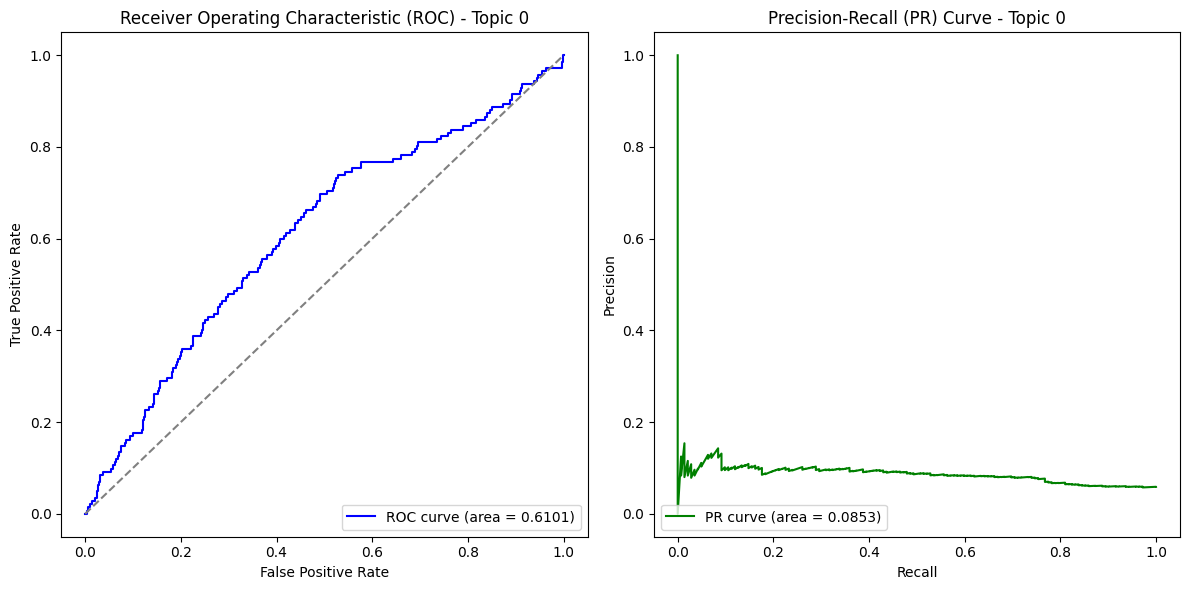

Evaluating topic 1
Topic 1 - auROC: 0.6140, auPR: 0.1126, F1: 0.0211


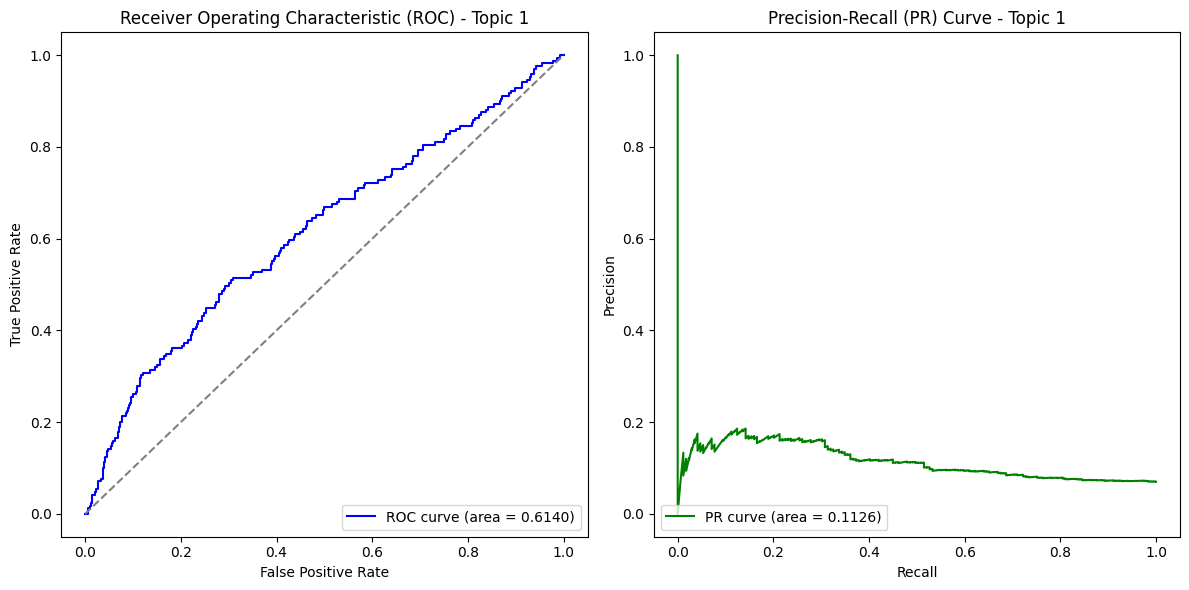

Evaluating topic 2
Topic 2 - auROC: 0.5547, auPR: 0.0735, F1: 0.0119


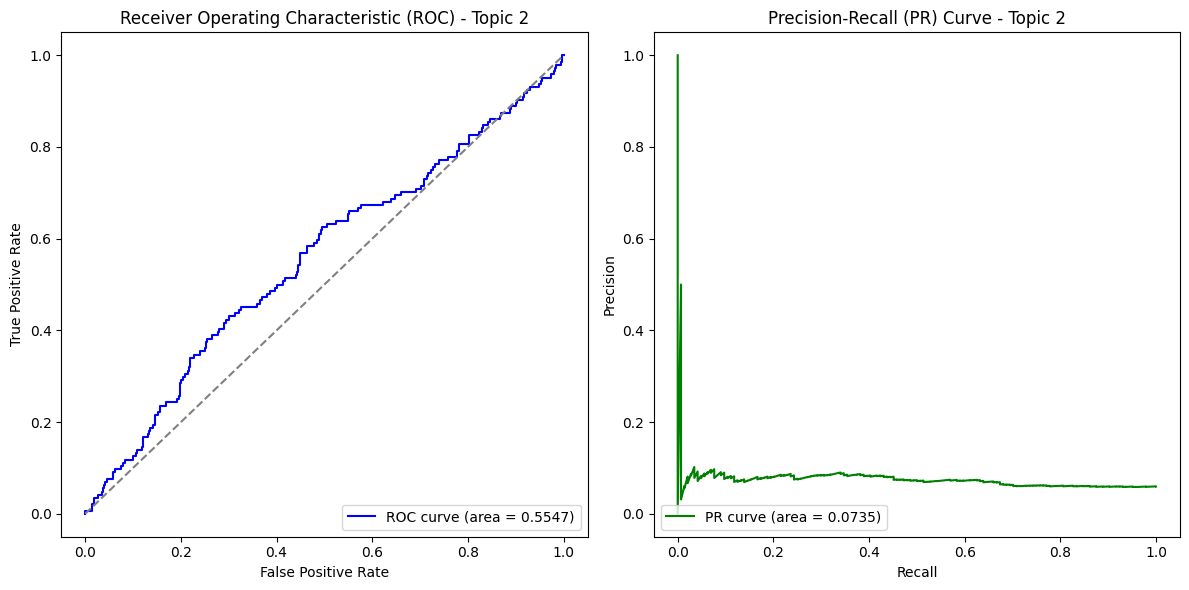

Evaluating topic 3
Topic 3 - auROC: 0.6031, auPR: 0.0814, F1: 0.0138


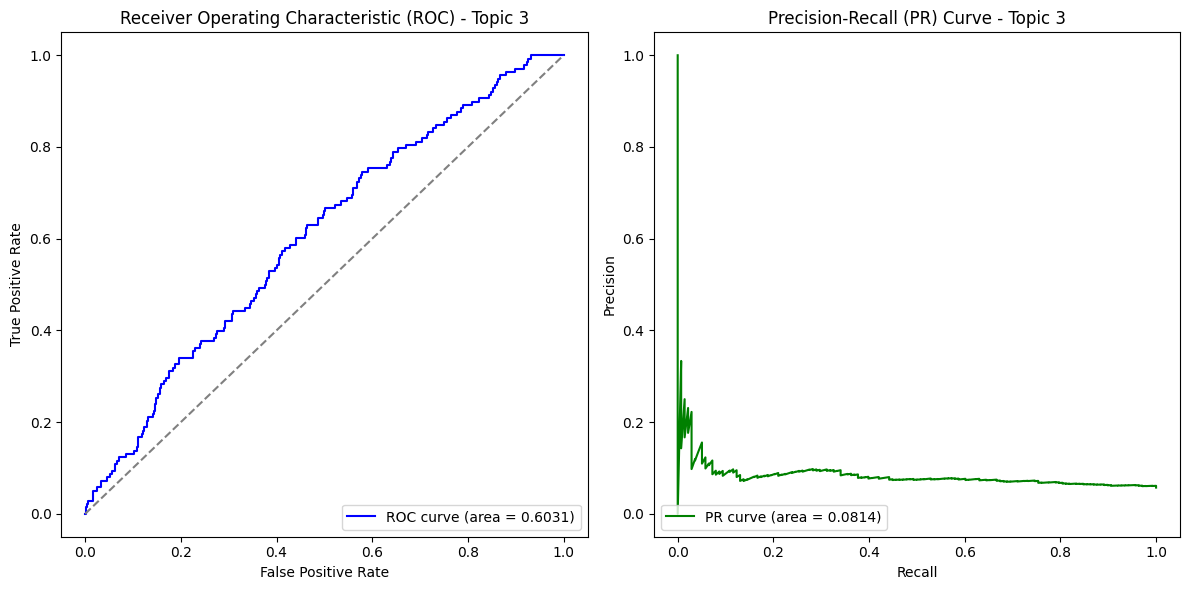

Evaluating topic 4
Topic 4 - auROC: 0.5449, auPR: 0.0732, F1: 0.0455


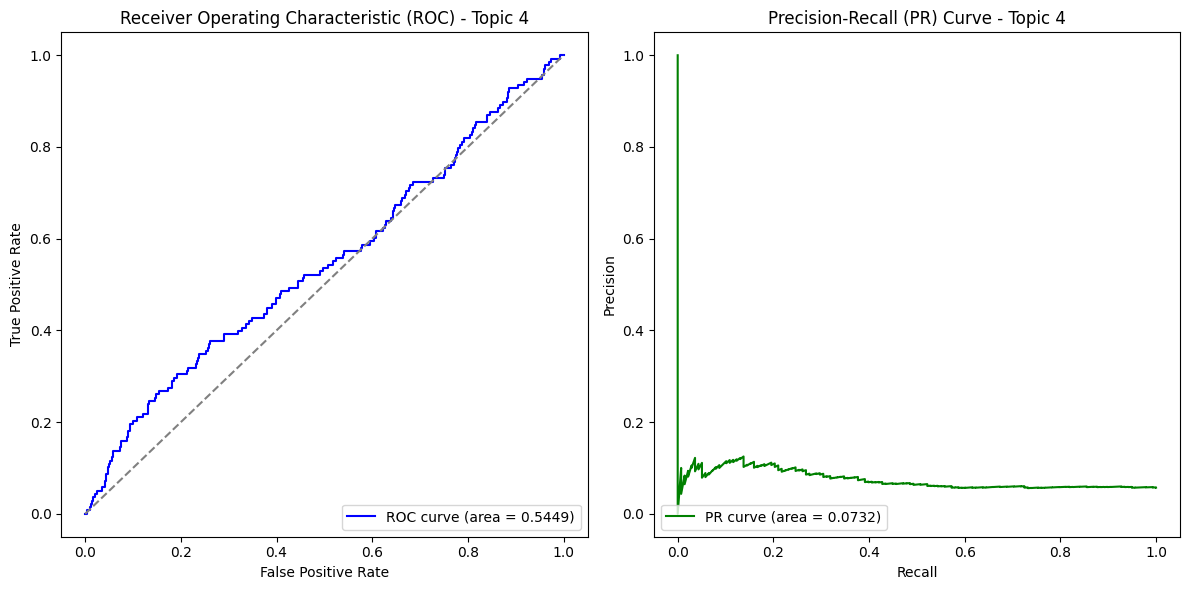

Evaluating topic 5
Topic 5 - auROC: 0.5034, auPR: 0.0646, F1: 0.0111


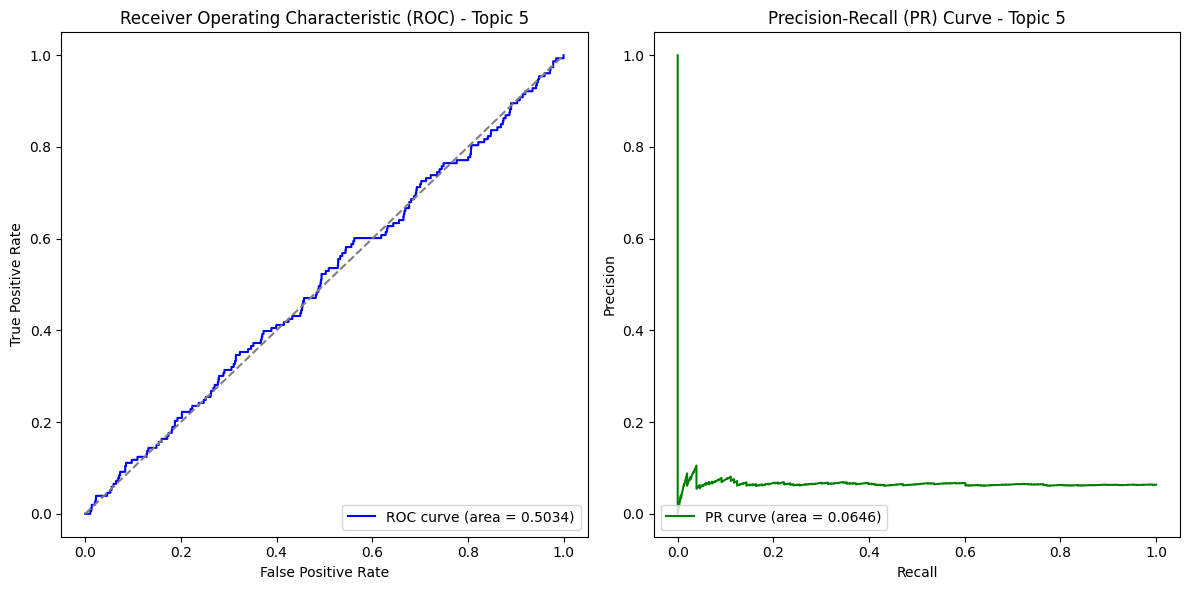

Evaluating topic 6
Topic 6 - auROC: 0.5885, auPR: 0.1044, F1: 0.0749


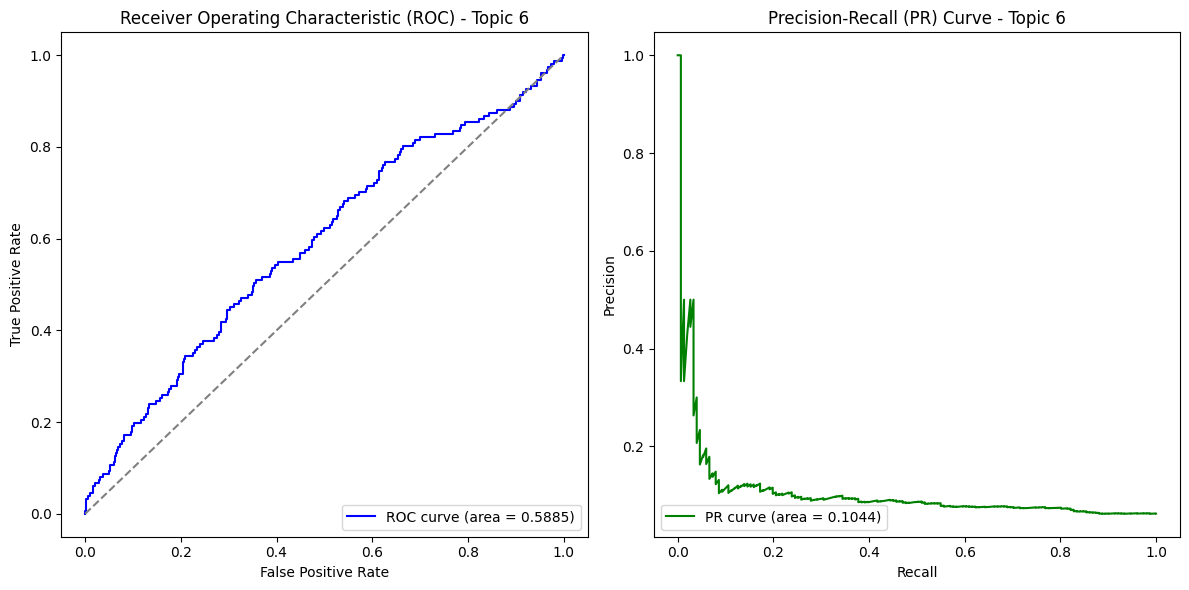

Evaluating topic 7
Topic 7 - auROC: 0.5657, auPR: 0.0770, F1: 0.0600


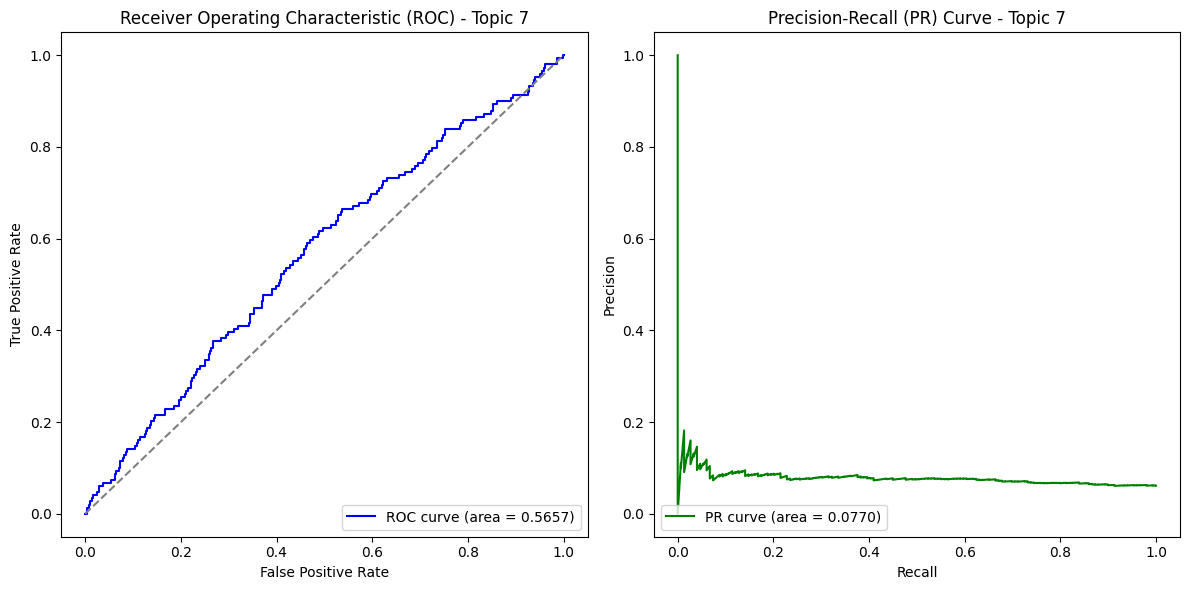

Evaluating topic 8
Topic 8 - auROC: 0.5303, auPR: 0.0708, F1: 0.0000


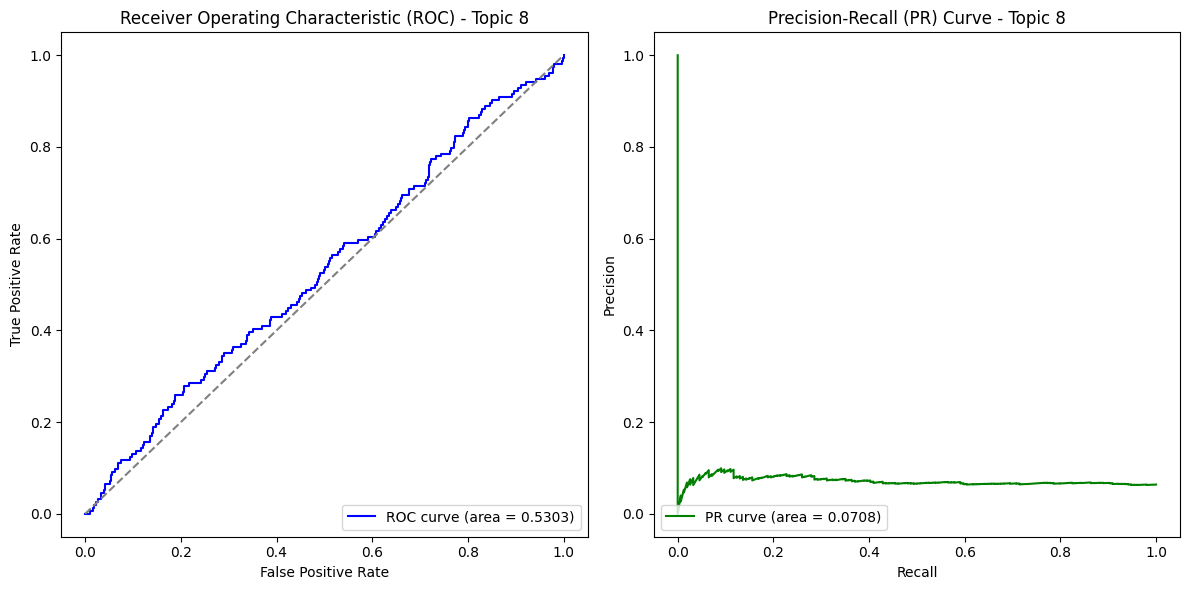

Evaluating topic 9
Topic 9 - auROC: 0.5420, auPR: 0.0896, F1: 0.0565


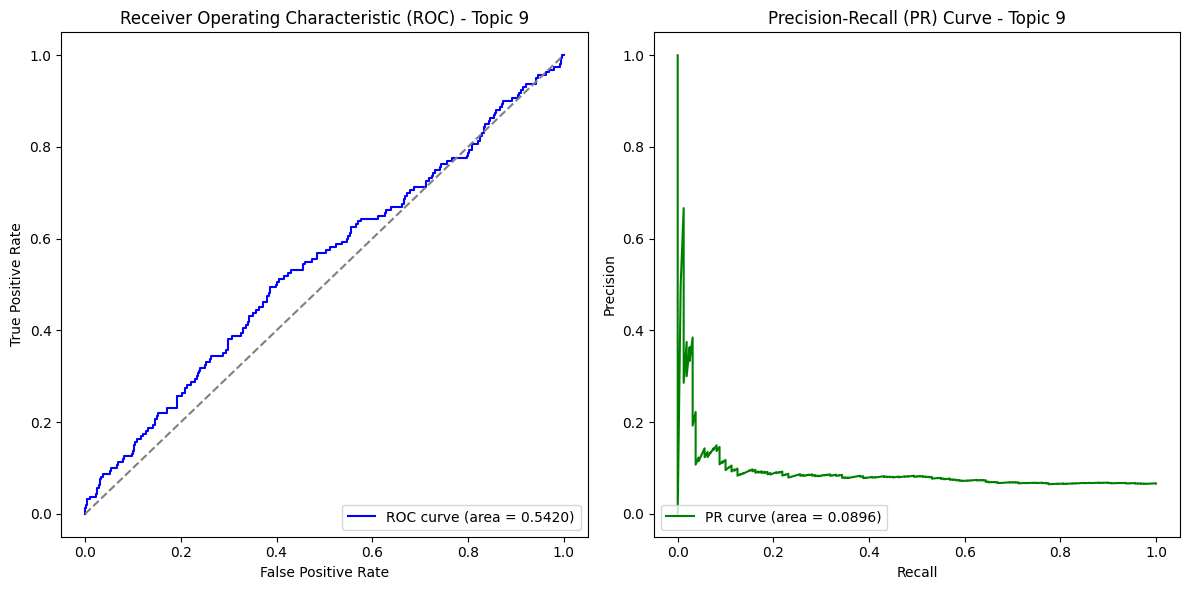

Evaluating topic 10
Topic 10 - auROC: 0.5822, auPR: 0.0802, F1: 0.0120


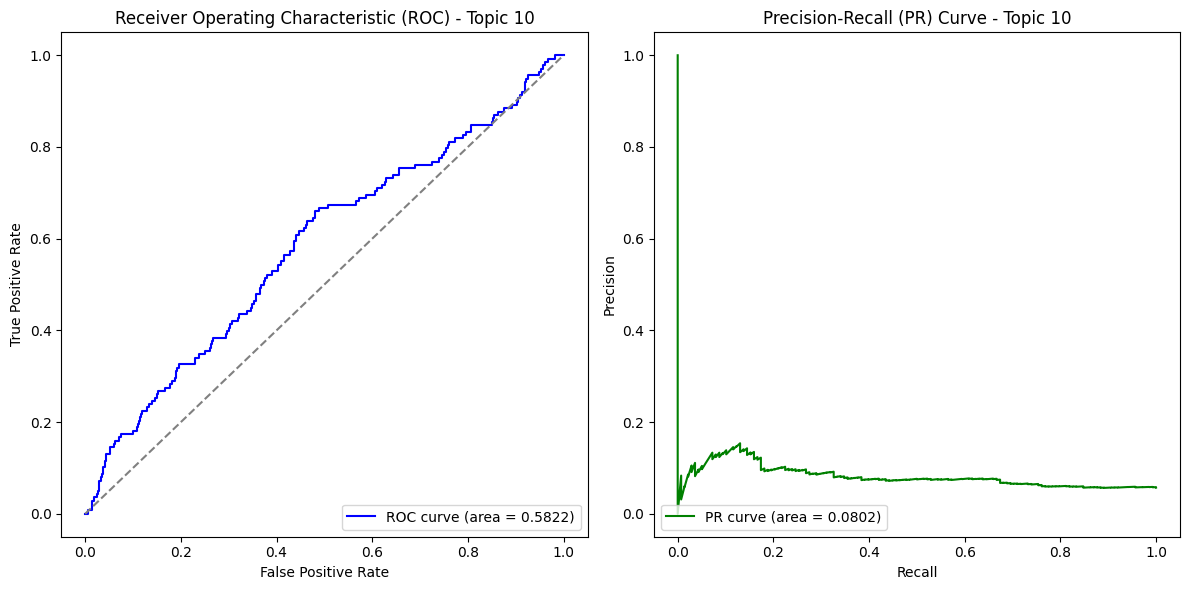

Evaluating topic 11
Topic 11 - auROC: 0.5725, auPR: 0.0833, F1: 0.0123


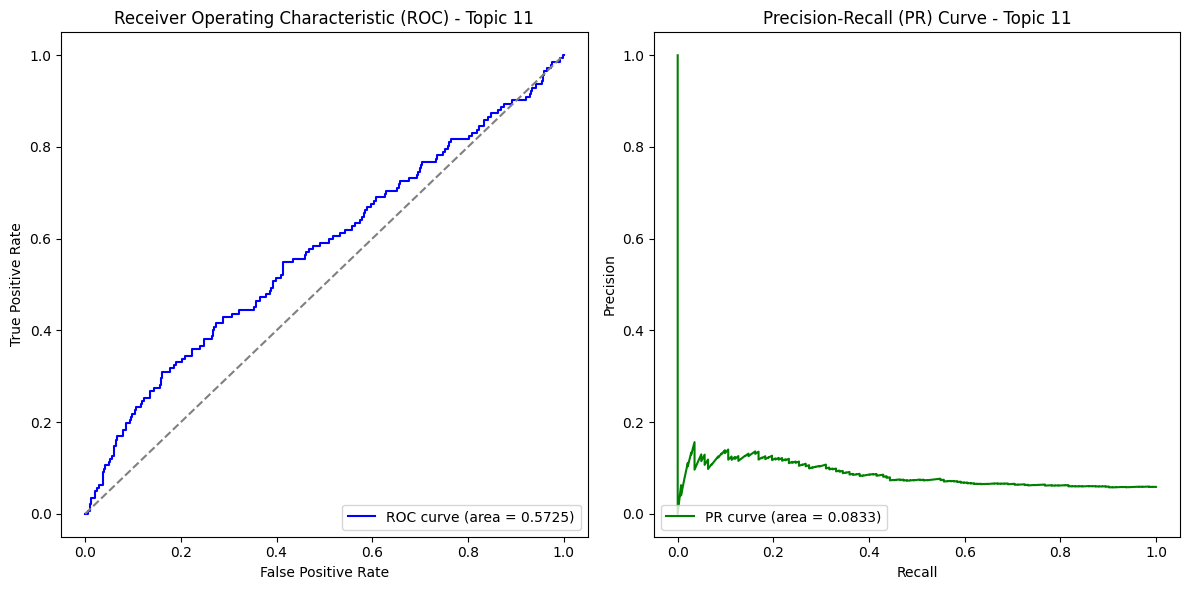

Evaluating topic 12
Topic 12 - auROC: 0.5357, auPR: 0.0778, F1: 0.0272


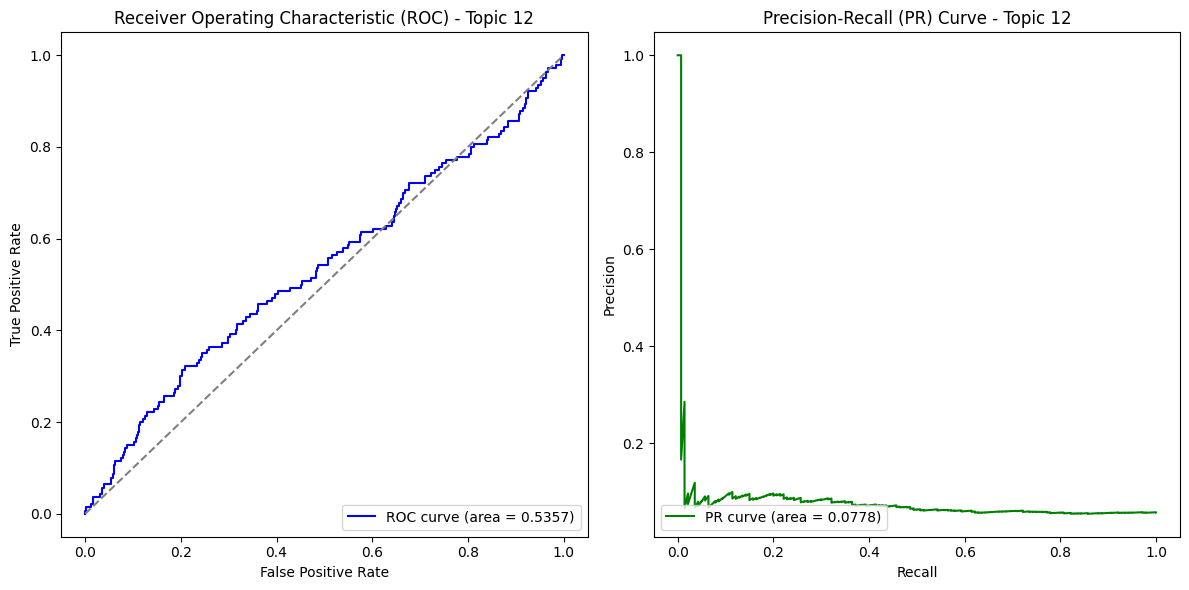

Evaluating topic 13
Topic 13 - auROC: 0.5789, auPR: 0.0845, F1: 0.0734


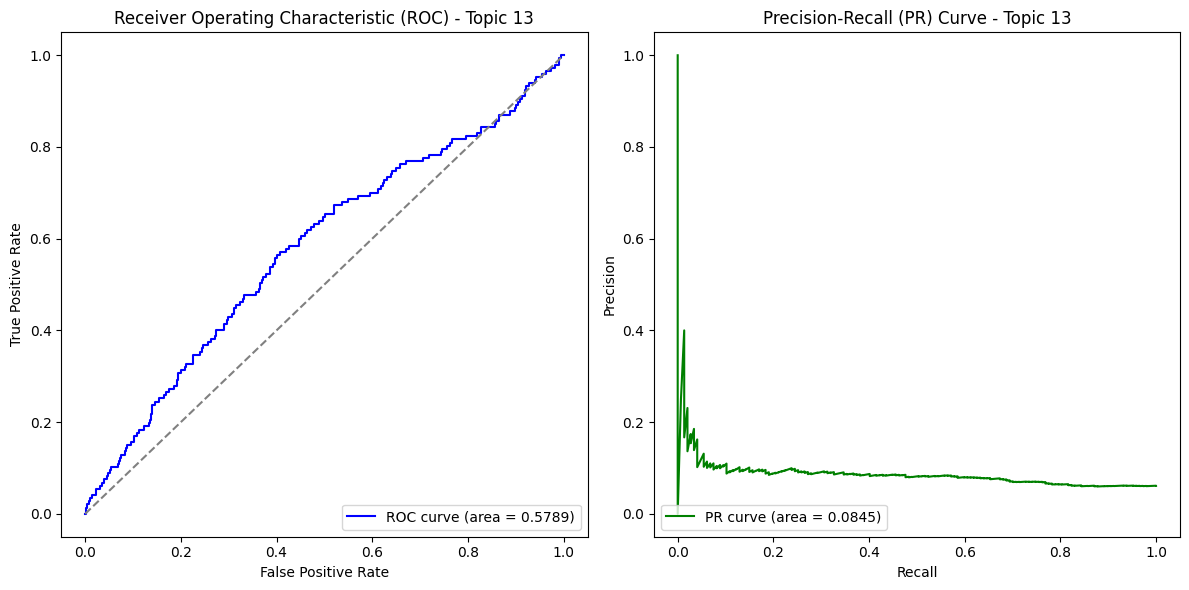

Evaluating topic 14
Topic 14 - auROC: 0.5939, auPR: 0.1074, F1: 0.0432


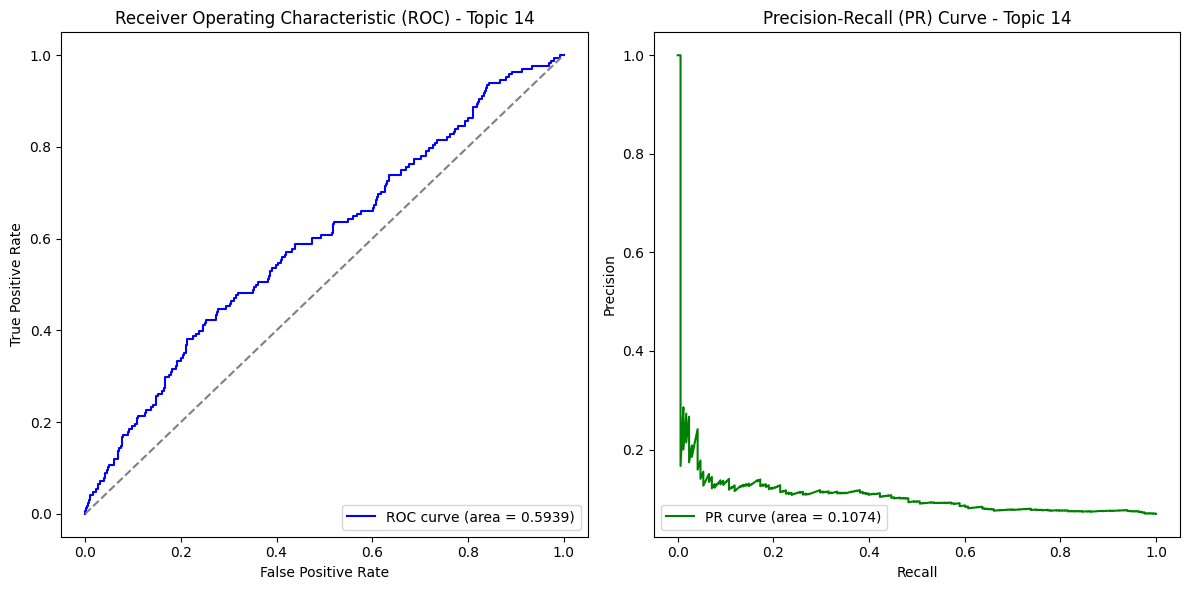

Evaluating topic 15
Topic 15 - auROC: 0.5238, auPR: 0.0712, F1: 0.0121


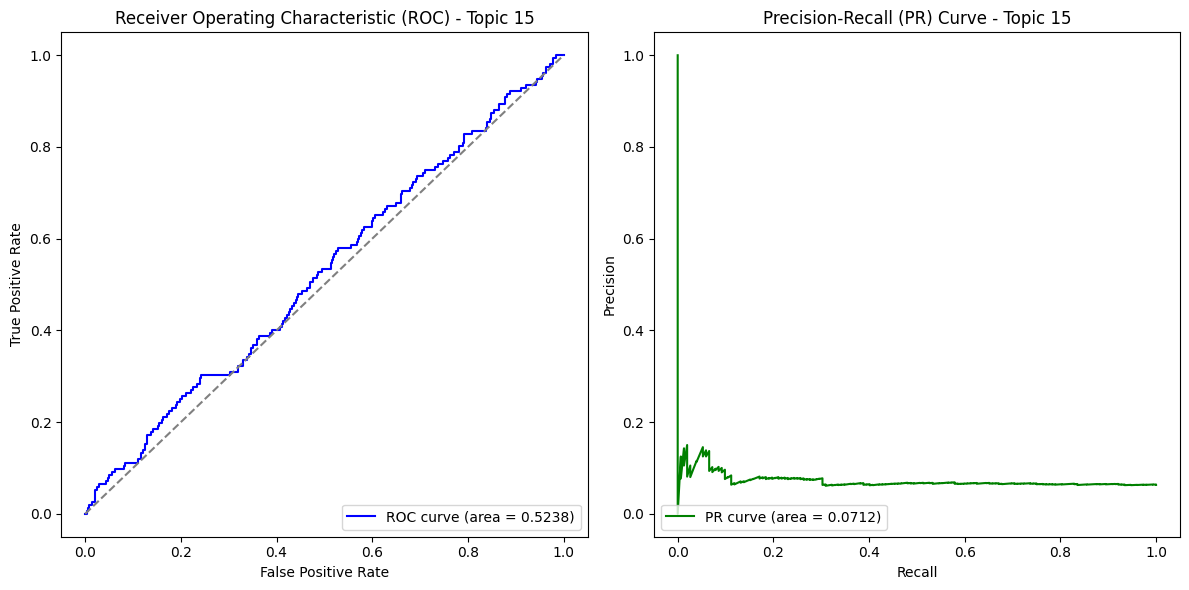

Evaluating topic 16
Topic 16 - auROC: 0.5566, auPR: 0.0916, F1: 0.0541


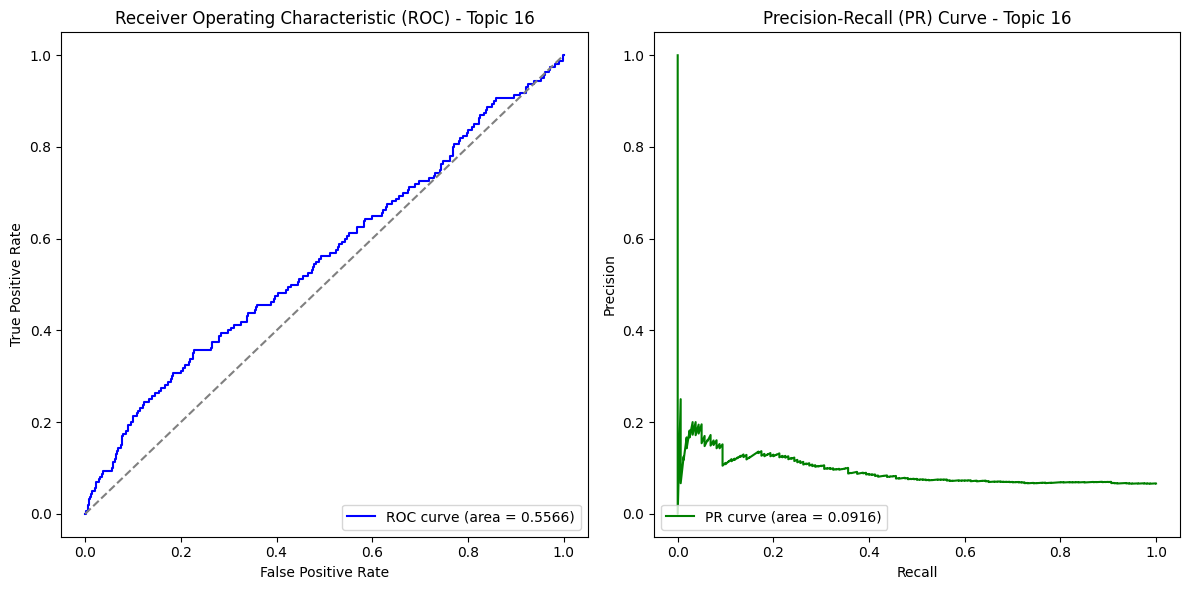

Evaluating topic 17
Topic 17 - auROC: 0.5414, auPR: 0.0648, F1: 0.0116


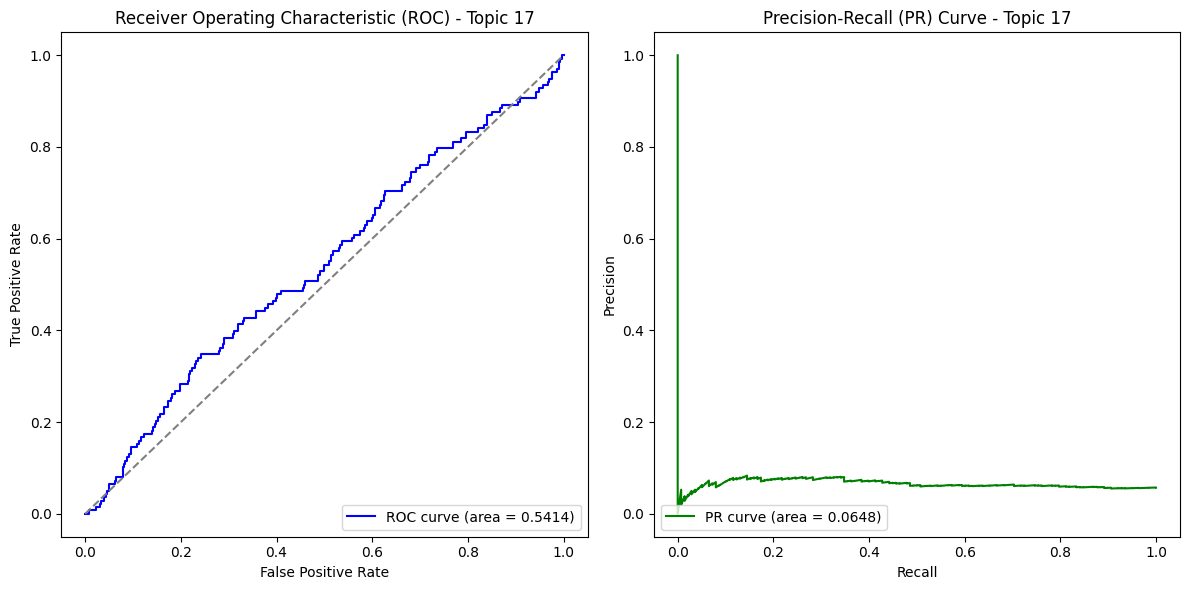

In [18]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.5634 ± 0.0307
Mean auPR: 0.0830 ± 0.0135
Mean F1: 0.0338 ± 0.0246
Exact Match Accuracy: 0.0029
Hamming Accuracy: 0.9291


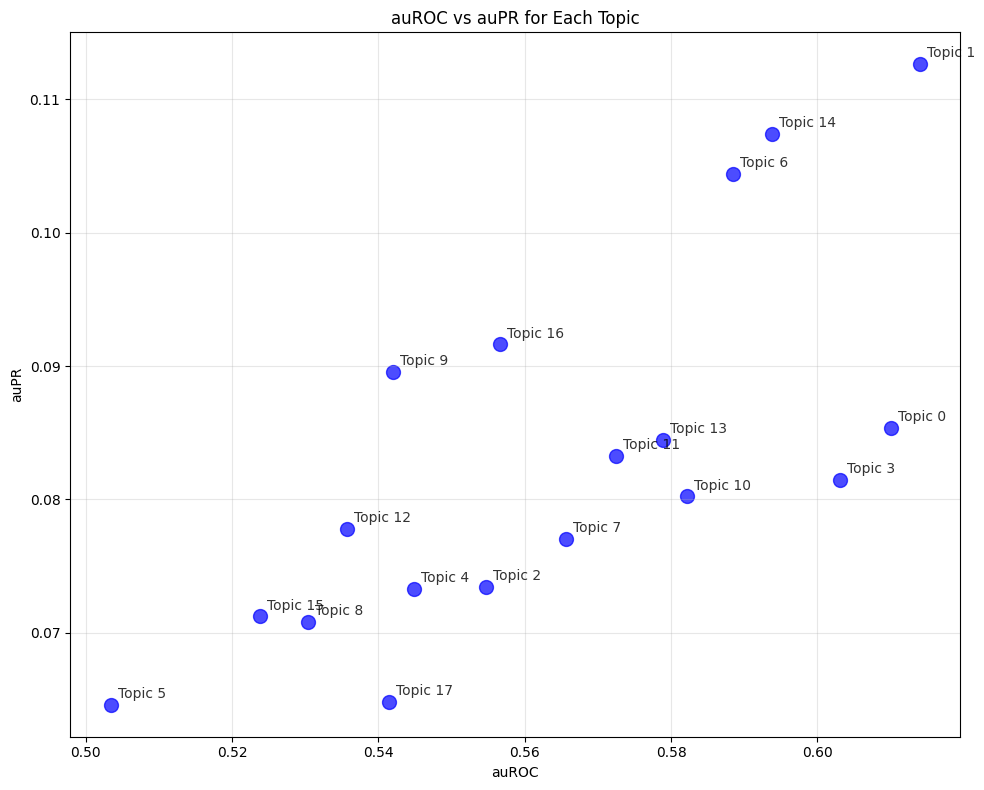

In [20]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

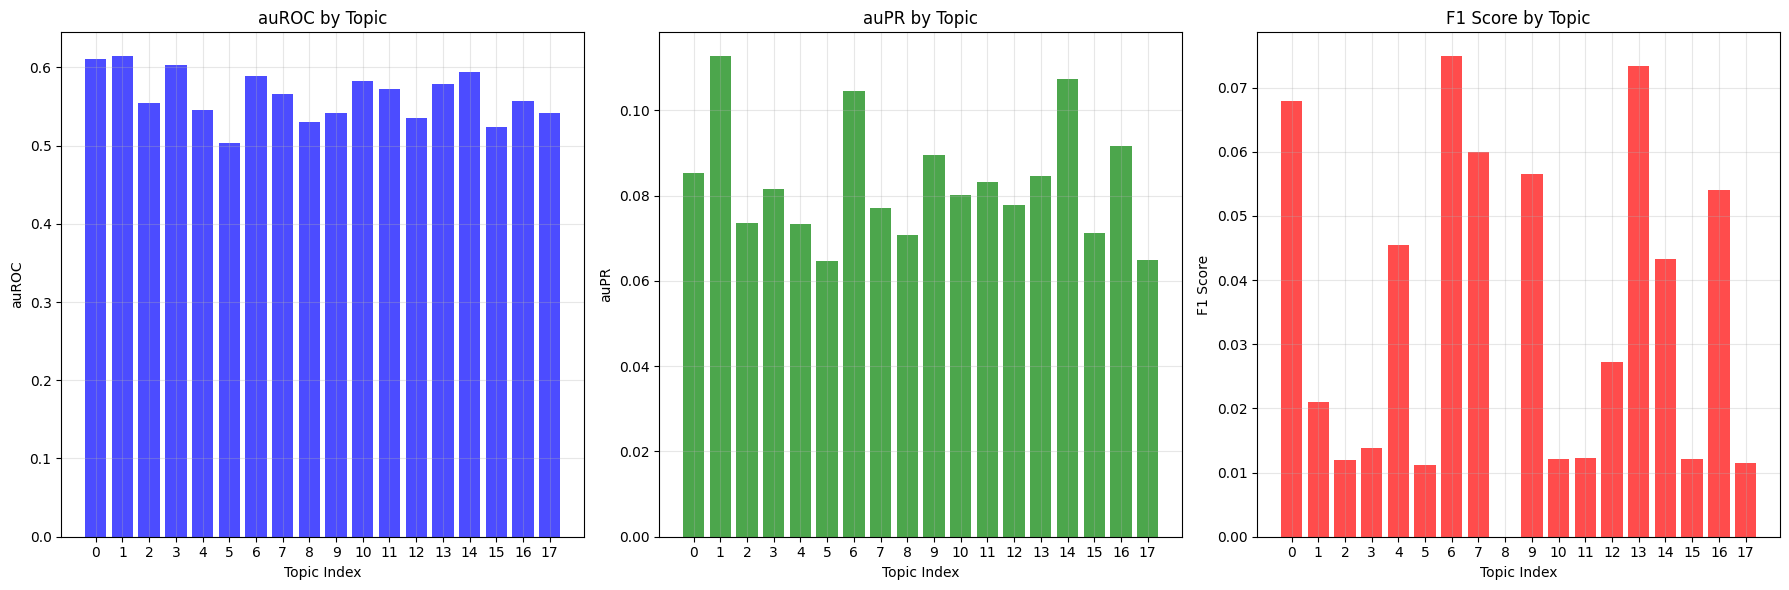

In [21]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

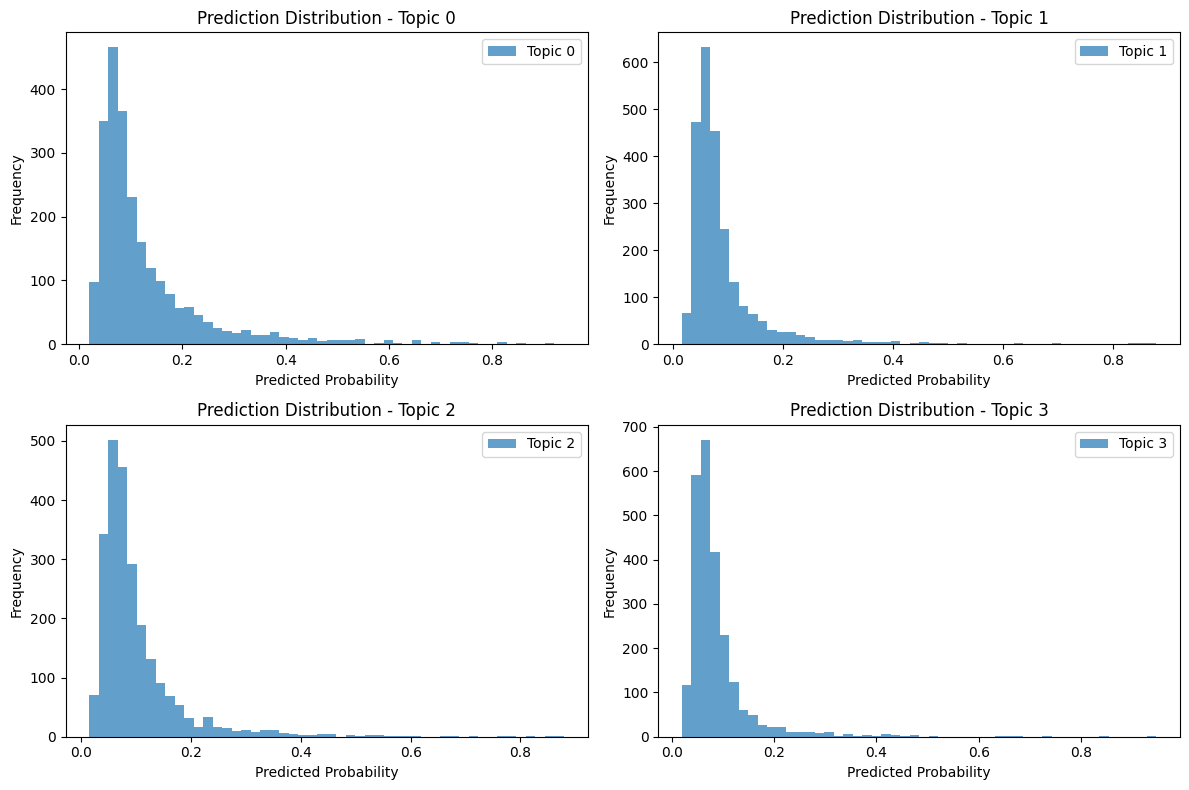


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.10284683 0.07878803 0.1267329  0.07695547 0.11597668 0.09300538
 0.09512118 0.15954255 0.07194497 0.08058936 0.13691877 0.11070535
 0.08389896 0.24320327 0.12511294 0.22569467 0.05537313 0.12548114]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.15824702 0.08499756 0.1143051  0.0816386  0.14615513 0.08094171
 0.13865507 0.06996508 0.09849112 0.09430312 0.07412507 0.0964246
 0.06255217 0.12333002 0.06156288 0.10824304 0.07605726 0.33082125]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.08815888 0.05191638 0.05236886 0.09789205 0.06869694 0.08524321
 0.04631781 0.3297559  0.09693598 0.13197728 0.04839094 0.08556928
 0.06263281 0.08482601 0.09674517 0.10453853 0.43768588 0.07151403]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 

In [22]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()